In [18]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt
import csv

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import functional as TF
import torch.nn.init as init
from torchsummary import summary

# Image preprocessing
from skimage.transform import resize

# Model and training utilities
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# Setup
import logging
import pickle 
import argparse

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir = Path("/work3/kvabo/PKGCTORG/newCT")

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

In [45]:

qcDirLiver = Path( "/work3/kvabo/predictions/qcLiverDsc1.0")
df = pd.read_csv(qcDirLiver /"resultsUpdate.csv")
df

case  slice          model       dsc      mvsf         prediction_file
0         0     45  qcLiverDsc1.0  0.681135  0.531180     0_slice_45_pred.npy
1         0     46  qcLiverDsc1.0  0.646582  0.666440     0_slice_46_pred.npy
2         0     47  qcLiverDsc1.0  0.826823  0.540484     0_slice_47_pred.npy
3         0     48  qcLiverDsc1.0  0.917887  0.479560     0_slice_48_pred.npy
4         0     49  qcLiverDsc1.0  0.880519  0.467543     0_slice_49_pred.npy
...     ...    ...            ...       ...       ...                     ...
19448   139    400  qcLiverDsc1.0  0.878717  0.487919  139_slice_400_pred.npy
19449   139    401  qcLiverDsc1.0  0.862745  0.535344  139_slice_401_pred.npy
19450   139    402  qcLiverDsc1.0  0.837533  0.570420  139_slice_402_pred.npy
19451   139    403  qcLiverDsc1.0  0.440418  0.779791  139_slice_403_pred.npy
19452   139    404  qcLiverDsc1.0  0.000000  1.000000  139_slice_404_pred.npy

[19453 rows x 6 columns]

In [63]:
nCase = 0
targetClass = 1
targetdsc = 0.1
qcDirLiver = Path( f"/work3/kvabo/predictions/qcLiverDsc{targetdsc}")
df = pd.read_csv(qcDirLiver /"resultsUpdate.csv")
liverSlices = df[(df["case"] == nCase)]

gtSeg0 = np.load(dir / f"labels-{nCase}.npy")
ct_path = dir / f"volume-{nCase}.npy"
Z = []
YHat = []
YZHat = []

n_total_slices = gtSeg0.shape[2]

# Preallocate volume of zeros
pred = np.zeros((512, 512, n_total_slices), dtype=np.float32)


for slice in range(n_total_slices):
    liverMask = np.zeros((512, 512), dtype=np.uint8)

    if slice in liverSlices["slice"].values:
        # Load predicted segmentation
        segPathLiver = qcDirLiver / f"{nCase}_slice_{slice}_pred.npy"
        segLiver = np.load(segPathLiver).astype(np.float32)
    
        # Resize to (512, 512)
        segLiver= Image.fromarray((segLiver * 255).astype(np.uint8))  # convert to image
        segLiver = TF.resize(segLiver, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)
    
        # Convert back to NumPy and binarize if needed
        segLiver = np.array(segLiver).astype(np.uint8) // 255  # back to [0, 1]
        # Set class label
        liverMask = segLiver

    # Assign class labels
    pred[:, :, slice] = liverMask  # kidney=4, liver=1
    
    
nii_path = "/work3/kvabo/PKGCTORG/CTORG/OrganSegmentations/labels-0.nii.gz"
nii = nib.load(nii_path)
orig_affine = nii.affine

# Save resized volume with the original affine
nib.save(nib.Nifti1Image(pred, affine=orig_affine), f"predCase{nCase}dsc{targetdsc}.nii.gz")
#nib.save(nifti_img, f"predicted_seg_case{0}.nii.gz")

In [55]:
GT = (np.array(gtSeg0 == targetClass).astype(np.uint8)).astype(np.float32)
nib.save(nib.Nifti1Image(GT, affine=orig_affine), f"GTCase{nCase}dsc{targetdsc}.nii.gz")

## Results

In [36]:
df = pd.read_csv(Path('evalResultsLiverV5.csv'))
predDSC3dcase0 = []
gtDSC3dcase0 = []
eps =0
subjects = df[(df["case"] == 0)]
nSlices = len(subjects)// 10
for i in range(10):
    subject = subjects[nSlices*i:nSlices*i + nSlices]
    Z = np.sum(subject['z'])
    Y = np.sum(subject['y'])
    YZ = np.sum(subject['yz'])
    gtDSC3dcase0.append((2*YZ/(Y+Z)))
        
    mvsf = subject['predmvsf']*4-2
    yHat = subject['z']*(2+mvsf)/(2-mvsf+eps)
    yzHat = 0.5*subject['preddsc']*(yHat + subject['z'])
        
    predDSC3dcase0.append(2*np.sum(yzHat)/(np.sum(yHat)+Z))

In [37]:
df

case  slice                                    path   preddsc  \
0         0     45  /work3/kvabo/predictions/qcLiverDsc1.0  0.623719   
1         0     46  /work3/kvabo/predictions/qcLiverDsc1.0  0.698920   
2         0     47  /work3/kvabo/predictions/qcLiverDsc1.0  0.869034   
3         0     48  /work3/kvabo/predictions/qcLiverDsc1.0  0.890104   
4         0     49  /work3/kvabo/predictions/qcLiverDsc1.0  0.835543   
...     ...    ...                                     ...       ...   
33275    21    521  /work3/kvabo/predictions/qcLiverDsc0.1  0.069842   
33276    21    522  /work3/kvabo/predictions/qcLiverDsc0.1  0.061697   
33277    21    523  /work3/kvabo/predictions/qcLiverDsc0.1  0.051947   
33278    21    524  /work3/kvabo/predictions/qcLiverDsc0.1  0.044209   
33279    21    525  /work3/kvabo/predictions/qcLiverDsc0.1  0.037729   

       predmvsf     gtdsc    gtmvsf        z            y           yz  
0      0.627675  0.681135  0.531180    245.0   277.588235   177.976471  
1      0.638586  0.646582  0.666440    287.0   573.415686   278.164706  
2      0.545225  0.826823  0.540484    650.0   764.533333   584.784314  
3      0.507657  0.917887  0.479560   1156.0  1065.196078  1019.403922  
4      0.417560  0.880519  0.467543   2327.0  2043.301961  1924.066667  
...         ...       ...       ...      ...          ...          ...  
33275  0.081293  0.024918  0.012554  48208.0   612.886275   608.254902  
33276  0.077926  0.020514  0.010257  48451.0   502.117647   502.117647  
33277  0.072282  0.014660  0.007330  48664.0   359.345098   359.345098  
33278  0.069053  0.009679  0.004840  49108.0   238.819608   238.819608  
33279  0.069333  0.003930  0.001965  49434.0    97.321569    97.321569  

[33280 rows x 10 columns]

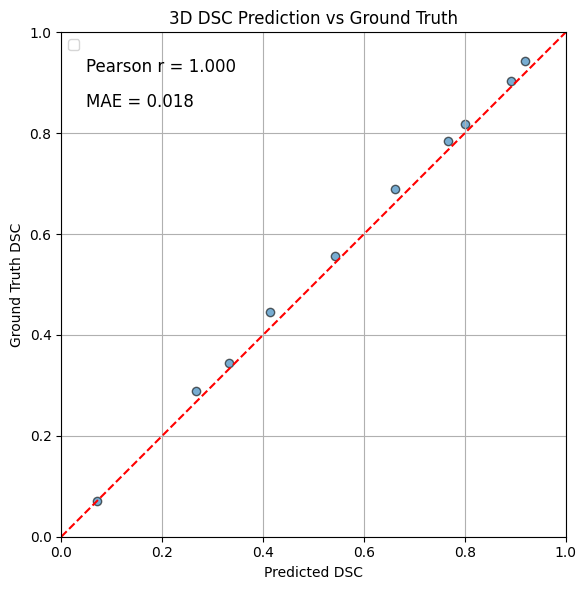

In [24]:
pred_dsc = predDSC3dcase0 
gt_dsc = gtDSC3dcase0
r, _ = pearsonr(pred_dsc, gt_dsc)

# Calculate Mean Absolute Error
mae = mean_absolute_error(gt_dsc, pred_dsc)

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--')

# Add metrics as text in the plot
plt.text(0.05, 0.95, f"Pearson r = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, f"MAE = {mae:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.xlabel('Predicted DSC')
plt.ylabel('Ground Truth DSC')
plt.title('3D DSC Prediction vs Ground Truth')
plt.grid(True)
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [156]:
df = pd.read_csv(Path('evalResultsBoneFinal.csv'))
predDSC3d = []
gtDSC3d = []
cases = np.arange(21)
eps = 1e-7
for case in cases:
    subjects = df[(df["case"] == case)]
    nSlices = len(subjects)// 10
    for i in range(10):
        subject = subjects[nSlices*i:nSlices*i + nSlices]
        Z = np.sum(subject['z'])
        Y = np.sum(subject['y'])
        YZ = np.sum(subject['yz'])
        gtDSC3d.append((2*YZ/(Y+Z+eps)))
        
        #gtmvsf = subject['gtmvsf']*4-2
        #gtyHat = subject['z']*(2+gtmvsf)/(2-gtmvsf+eps)
        #gtyzHat = 0.5*subject['gtdsc']*(gtyHat + subject['z'])
        
        #gtDSC3d.append(2*np.sum(gtyzHat)/(np.sum(gtyHat)+Z))
        
        mvsf = subject['predmvsf']*4-2
        yHat = subject['z']*(2+mvsf)/(2-mvsf+eps)
        yzHat = 0.5*subject['preddsc']*(yHat + subject['z'])
        
        predDSC3d.append(2*np.sum(yzHat)/(np.sum(yHat)+Z+eps))

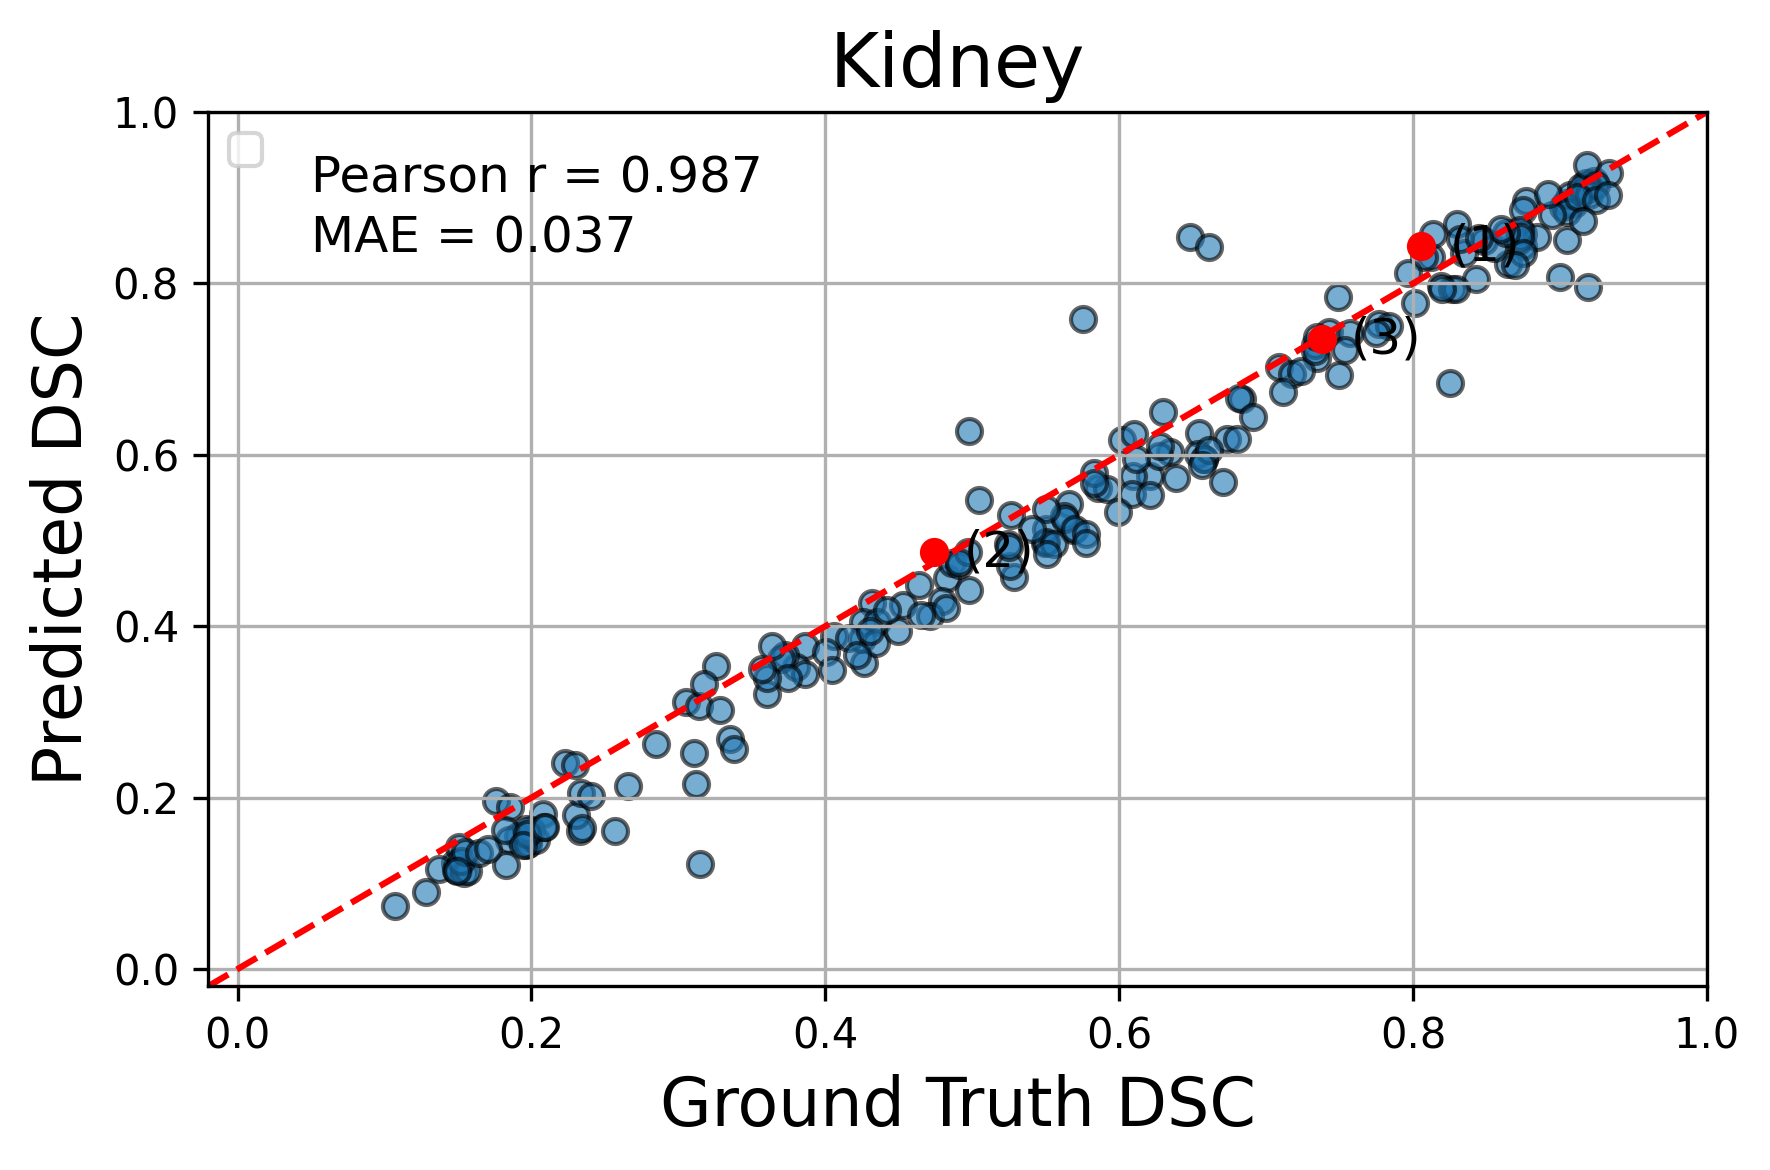

In [157]:
pred_dsc = np.array(predDSC3d )
gt_dsc = np.array(gtDSC3d)
r, _ = pearsonr(gt_dsc, pred_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))

# Create scatter plot
plt.figure(figsize=(6, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([-0.02, 1], [-0.02, 1], 'r--')
plt.plot(gt_dsc[10], pred_dsc[10], 'o', markersize=6, color='red')
plt.text(gt_dsc[10] + 0.02, pred_dsc[10], "(1)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[77], pred_dsc[77], 'o', markersize=6, color='red')
plt.text(gt_dsc[77] + 0.02, pred_dsc[77], "(2)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[152], pred_dsc[152], 'o', markersize=6, color='red')
plt.text(gt_dsc[152] + 0.02, pred_dsc[152], "(3)", fontsize=12, verticalalignment='center')

# Add metrics as text in the plot
plt.text(0.05, 0.95, f"Pearson r = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, f"MAE = {mae:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Kidney',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Liver

In [19]:
df = pd.read_csv(Path('evalResultsLiverfinal.csv'))
predDSC3d = []
gtDSC3d = []
caseList = []
pathList = []
cases = np.arange(21)
eps = 1e-7
for case in cases:
    subjects = df[(df["case"] == case)]
    nSlices = len(subjects)// 10
    for i in range(10):
        subject = subjects[nSlices*i:nSlices*i + nSlices]
        Z = np.sum(subject['z'])
        Y = np.sum(subject['y'])
        YZ = np.sum(subject['yz'])
        gtDSC3d.append((2*YZ/(Y+Z+eps)))
        
        #gtmvsf = subject['gtmvsf']*4-2
        #gtyHat = subject['z']*(2+gtmvsf)/(2-gtmvsf+eps)
        #gtyzHat = 0.5*subject['gtdsc']*(gtyHat + subject['z'])
        
        #gtDSC3d.append(2*np.sum(gtyzHat)/(np.sum(gtyHat)+Z))
        
        mvsf = subject['predmvsf']*4-2
        yHat = subject['z']*(2+mvsf)/(2-mvsf+eps)
        yzHat = 0.5*subject['preddsc']*(yHat + subject['z'])

        pathList.append(subject['path'].iloc[0])
        caseList.append(case)
        predDSC3d.append(2*np.sum(yzHat)/(np.sum(yHat)+Z+eps))


In [299]:
print(np.where((gt_dsc > 0.49) & (gt_dsc < 0.55)))


(array([ 15,  25,  35,  54,  75, 115, 135, 155, 175, 196, 197, 205]),)


In [300]:
np.where(np.abs(pred_dsc-gt_dsc) < 0.01)

(array([  2,   3,   4,   6,  11,  12,  14,  17,  20,  21,  25,  27,  29,
         33,  34,  35,  36,  37,  43,  50,  51,  52,  53,  54,  58,  59,
         65,  66,  67,  68,  69,  73,  74,  75,  76,  77,  78,  79,  82,
         83,  84,  85,  86,  87,  88,  89,  92,  93,  94,  95,  97,  98,
         99, 101, 104, 105, 106, 107, 108, 109, 117, 119, 120, 121, 122,
        123, 124, 126, 129, 130, 131, 132, 133, 138, 140, 144, 145, 148,
        149, 150, 151, 152, 153, 158, 160, 161, 162, 163, 164, 166, 168,
        170, 173, 175, 178, 180, 181, 182, 183, 184, 185, 189, 198, 199]),)

In [301]:
num = 35
print(caseList[num], pathList[num], gt_dsc[num],pred_dsc[num])

3 /work3/kvabo/predictions/qcLiverDsc0.5 0.5235104925329361 0.5221415797100238


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


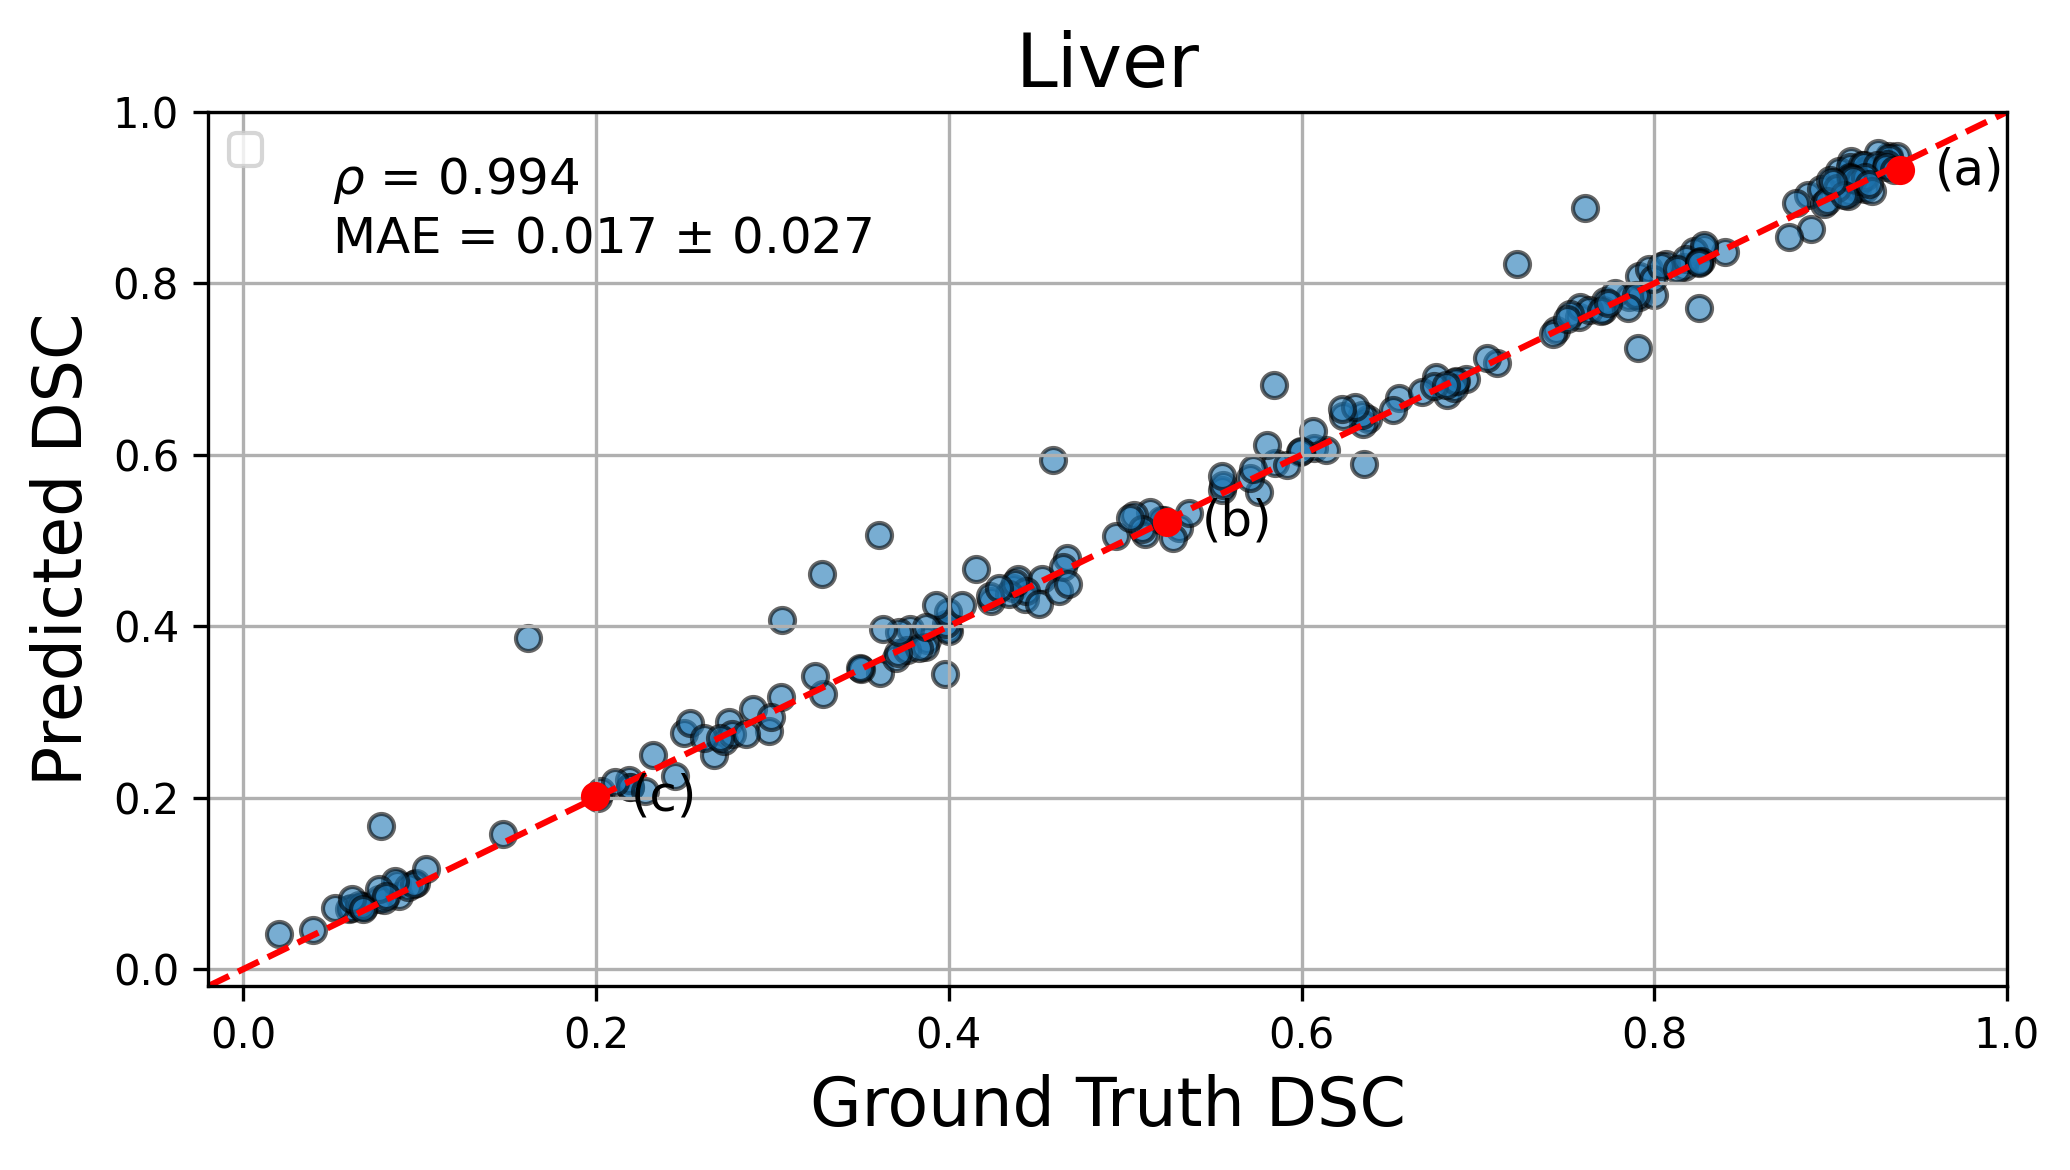

In [20]:
pred_dsc = np.array(predDSC3d )
gt_dsc = np.array(gtDSC3d)
r, _ = pearsonr(gt_dsc, pred_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))
aeLiver = np.abs(pred_dsc-gt_dsc)

# Create scatter plot
plt.figure(figsize=(7, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([-0.02, 1], [-0.02, 1], 'r--')
plt.plot(gt_dsc[140], pred_dsc[140], 'o', markersize=6, color='red')
plt.text(gt_dsc[140] + 0.02, pred_dsc[140], "(a)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[35], pred_dsc[35], 'o', markersize=6, color='red')
plt.text(gt_dsc[35] + 0.02, pred_dsc[35], "(b)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[98], pred_dsc[98], 'o', markersize=6, color='red')
plt.text(gt_dsc[98] + 0.02, pred_dsc[98], "(c)", fontsize=12, verticalalignment='center')

# Add metrics as text in the plot
plt.text(0.05, 0.95, fr"$\rho$ = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, fr"MAE = {mae:.3f} $\pm$ {std:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Liver',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.savefig("corrLiver.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
pred = np.array(predDSC3d)
gt = np.array(gtDSC3d)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 1.000


## 2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


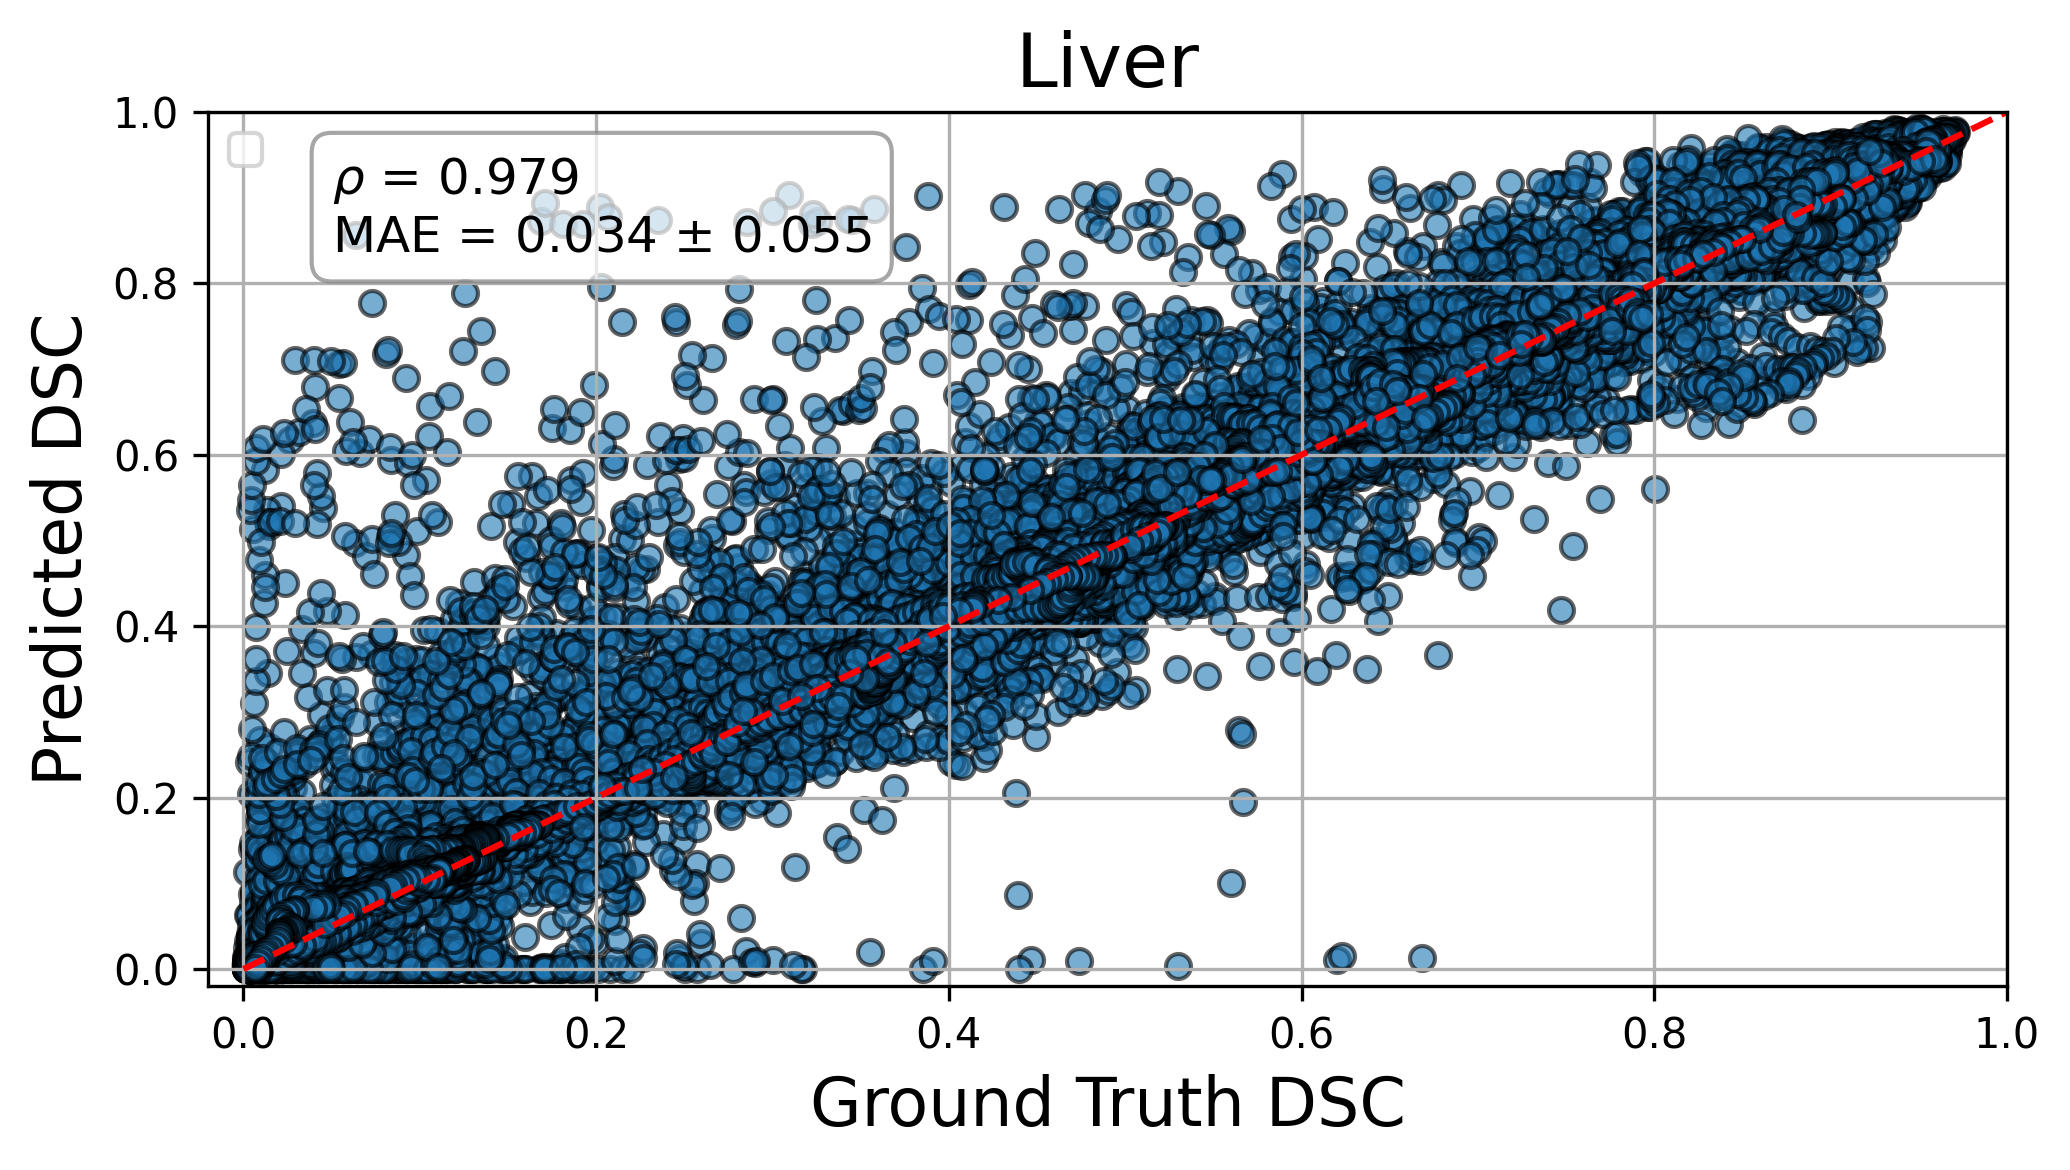

In [41]:
pred_dsc = df['preddsc']
gt_dsc = df['gtdsc']
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

# Example data (replace with your actual arrays)
# pred_dsc = ...
# gt_dsc = ...

# Calculate Pearson correlation coefficient
r, _ = pearsonr(pred_dsc, gt_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))
aeLiver2d = np.abs(pred_dsc-gt_dsc)


# Create scatter plot
plt.figure(figsize=(7, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--')


# Combine metrics into one multiline string
metrics_text = fr"$\rho$ = {r:.3f}" + "\n" + fr"MAE = {mae:.3f} $\pm$ {std:.3f}"

# Add single text box
plt.text(0.05, 0.95, metrics_text,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha = 0.7))


# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Liver',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.savefig("corrLiver2d.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [42]:
pred = np.array(pred_dsc)
gt = np.array(gt_dsc)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.967


In [315]:
num = 35
print(caseList[num], pathList[num], gt_dsc[num],pred_dsc[num])

3 /work3/kvabo/predictions/qcLiverDsc0.5 0.5235104925329361 0.5221415797100238


In [310]:
nCase = 13
targetClass = 1
targetdsc = 1.0
organ = 'Liver'
qcDirLiver = Path( f"/work3/kvabo/predictions/qc{organ}Dsc{targetdsc}")
df = pd.read_csv(qcDirLiver /"resultsUpdate.csv")
liverSlices = df[(df["case"] == nCase)]

gtSeg0 = np.load(dir / f"labels-{nCase}.npy")
ct_path = dir / f"volume-{nCase}.npy"
Z = []
YHat = []
YZHat = []

n_total_slices = gtSeg0.shape[2]

# Preallocate volume of zeros
pred = np.zeros((512, 512, n_total_slices), dtype=np.float32)


for slice in range(n_total_slices):
    liverMask = np.zeros((512, 512), dtype=np.uint8)

    if slice in liverSlices["slice"].values:
        # Load predicted segmentation
        segPathLiver = qcDirLiver / f"{nCase}_slice_{slice}_pred.npy"
        segLiver = np.load(segPathLiver).astype(np.float32)
    
        # Resize to (512, 512)
        segLiver= Image.fromarray((segLiver * 255).astype(np.uint8))  # convert to image
        segLiver = TF.resize(segLiver, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)
    
        # Convert back to NumPy and binarize if needed
        segLiver = np.array(segLiver).astype(np.uint8) // 255  # back to [0, 1]
        # Set class label
        liverMask = segLiver

    # Assign class labels
    pred[:, :, slice] = liverMask  # kidney=4, liver=1
    
    
nii_path = f"/work3/kvabo/PKGCTORG/CTORG/OrganSegmentations/labels-{nCase}.nii.gz"
nii = nib.load(nii_path)
orig_affine = nii.affine

# Save resized volume with the original affine
nib.save(nib.Nifti1Image(pred, affine=orig_affine), f"{organ}predCase{nCase}dsc{targetdsc}.nii.gz")
#nib.save(nifti_img, f"predicted_seg_case{0}.nii.gz")
GT = (np.array(gtSeg0 == targetClass).astype(np.uint8)).astype(np.float32)
nib.save(nib.Nifti1Image(GT, affine=orig_affine), f"{organ}GTCase{nCase}dsc{targetdsc}.nii.gz")

In [316]:
print(f"{organ}predCase{nCase}dsc{targetdsc}")

LiverpredCase13dsc1.0


# Bone

In [59]:
df = pd.read_csv(Path('evalResultsBoneFinal.csv'))
predDSC3d = []
gtDSC3d = []
caseList = []
pathList = []
cases = np.arange(21)
eps = 1e-7
for case in cases:
    subjects = df[(df["case"] == case)]
    nSlices = len(subjects)// 10
    for i in range(10):
        subject = subjects[nSlices*i:nSlices*i + nSlices]
        Z = np.sum(subject['z'])
        Y = np.sum(subject['y'])
        YZ = np.sum(subject['yz'])
        gtDSC3d.append((2*YZ/(Y+Z+eps)))
        
        #gtmvsf = subject['gtmvsf']*4-2
        #gtyHat = subject['z']*(2+gtmvsf)/(2-gtmvsf+eps)
        #gtyzHat = 0.5*subject['gtdsc']*(gtyHat + subject['z'])
        
        #gtDSC3d.append(2*np.sum(gtyzHat)/(np.sum(gtyHat)+Z))
        
        mvsf = subject['predmvsf']*4-2
        yHat = subject['z']*(2+mvsf)/(2-mvsf+eps)
        yzHat = 0.5*subject['preddsc']*(yHat + subject['z'])

        pathList.append(subject['path'].iloc[0])
        caseList.append(case)
        predDSC3d.append(2*np.sum(yzHat)/(np.sum(yHat)+Z+eps))


In [349]:
print(np.where((gt_dsc > 0.2) & (gt_dsc < 0.3)))


(array([  7,   8,  17,  18, 158, 168, 188, 197, 198, 208]),)


In [346]:
np.where(np.abs(pred_dsc-gt_dsc) < 0.02)


(array([  8,  16,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  33,
         36,  39,  40,  41,  42,  49,  50,  53,  57,  60,  61,  70,  71,
         73,  77,  80,  90,  91,  97, 100, 101, 102, 103, 107, 110, 111,
        112, 113, 117, 119, 120, 121, 122, 127, 131, 133, 137, 140, 142,
        143, 147, 150, 152, 153, 154, 155, 157, 159, 160, 161, 163, 164,
        165, 166, 191, 194]),)

In [361]:
num = 154
print(caseList[num], pathList[num], gt_dsc[num],pred_dsc[num])

15 /work3/kvabo/predictions/qcBoneDsc0.6 0.537002274947051 0.5501134851661963


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


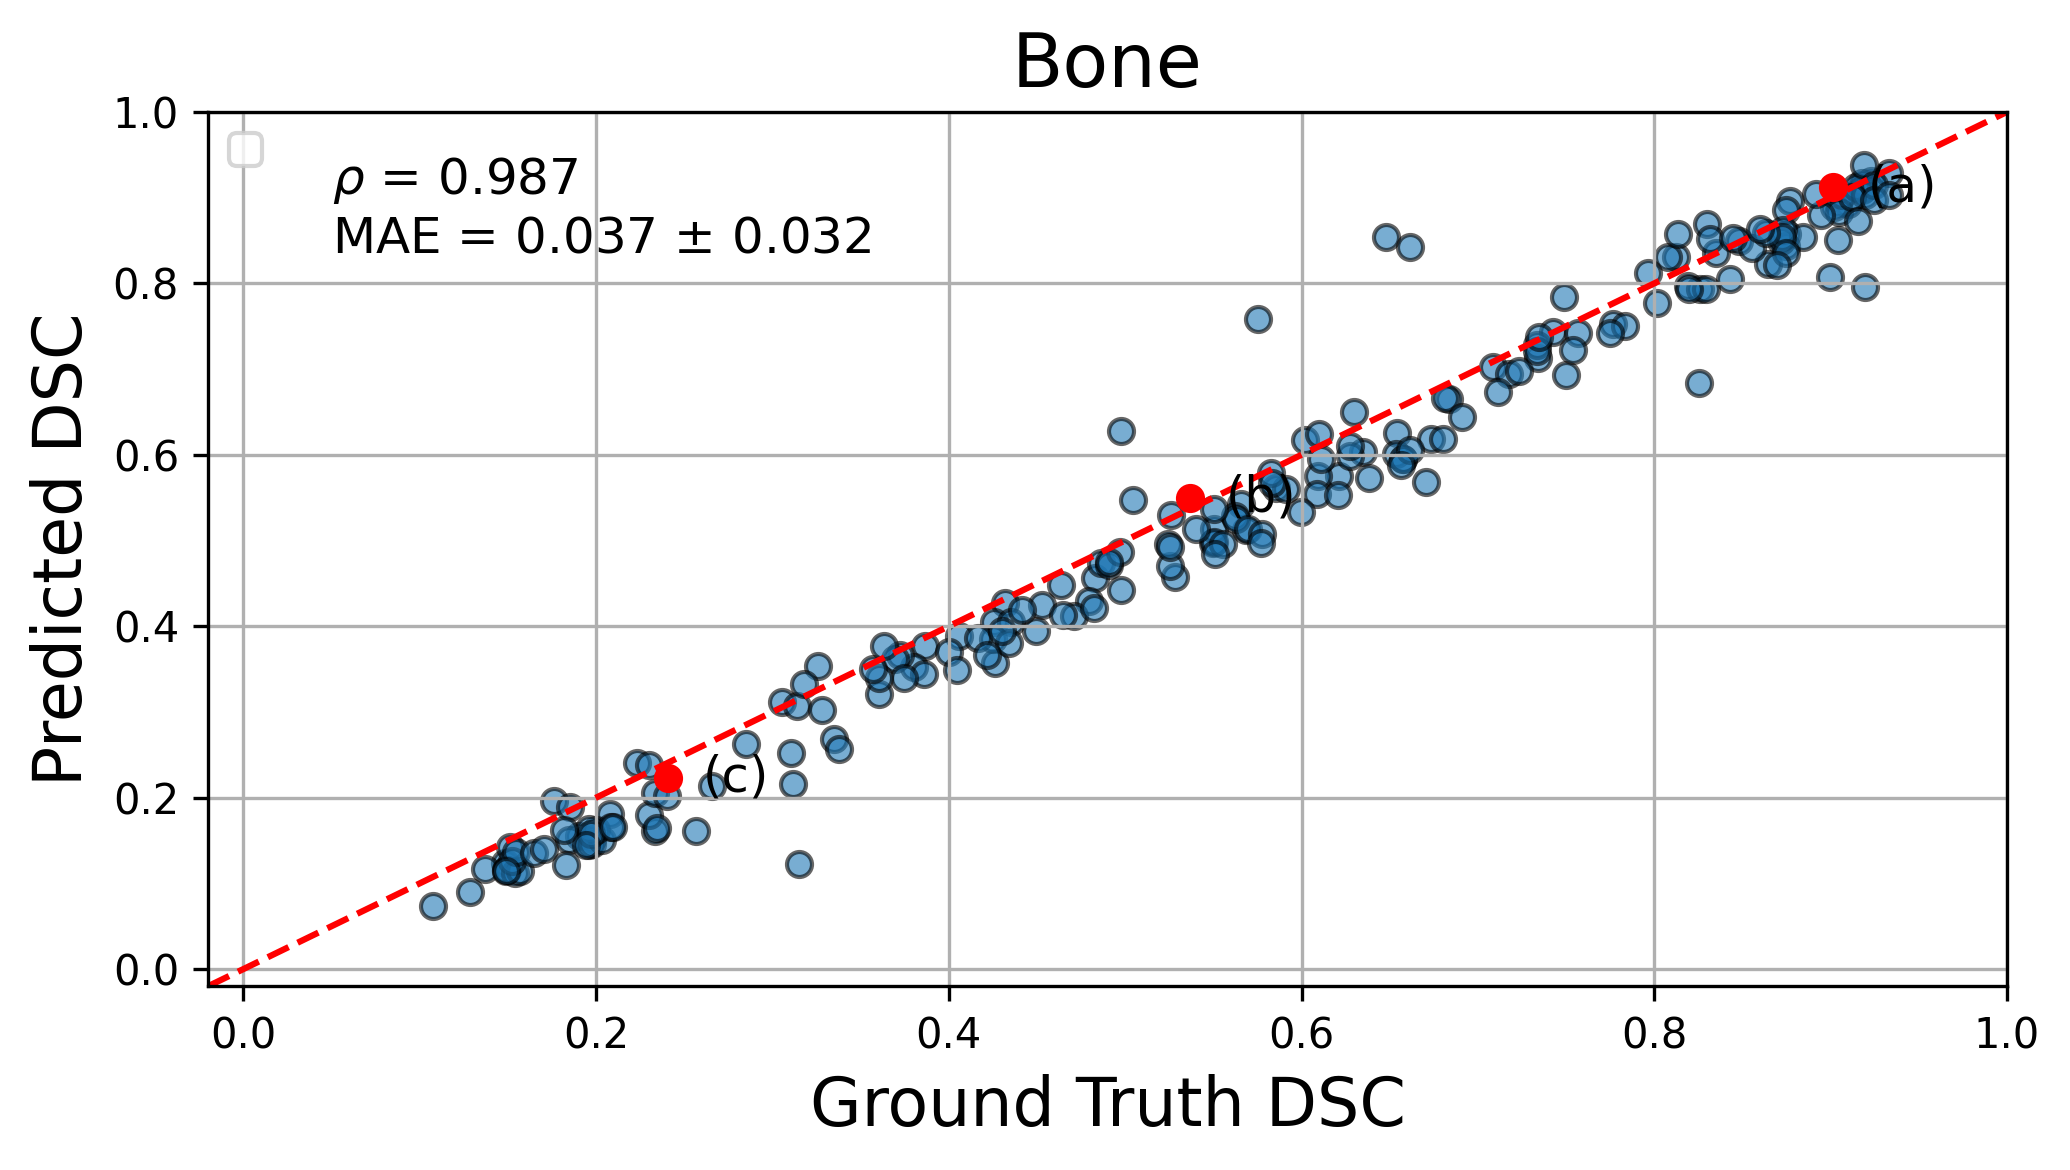

In [60]:
pred_dsc = np.array(predDSC3d )
gt_dsc = np.array(gtDSC3d)
r, _ = pearsonr(gt_dsc, pred_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))
aeBone = np.abs(pred_dsc-gt_dsc)

# Create scatter plot
plt.figure(figsize=(7, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([-0.02, 1], [-0.02, 1], 'r--')
plt.plot(gt_dsc[121], pred_dsc[121], 'o', markersize=6, color='red')
plt.text(gt_dsc[121] + 0.02, pred_dsc[121], "(a)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[154], pred_dsc[154], 'o', markersize=6, color='red')
plt.text(gt_dsc[154] + 0.02, pred_dsc[154], "(b)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[8], pred_dsc[8], 'o', markersize=6, color='red')
plt.text(gt_dsc[8] + 0.02, pred_dsc[8], "(c)", fontsize=12, verticalalignment='center')

# Add metrics as text in the plot
plt.text(0.05, 0.95, fr"$\rho$ = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, fr"MAE = {mae:.3f} $\pm$ {std:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Bone',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.savefig("corrBone.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [61]:
pred = np.array(predDSC3d)
gt = np.array(gtDSC3d)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.962


## 2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


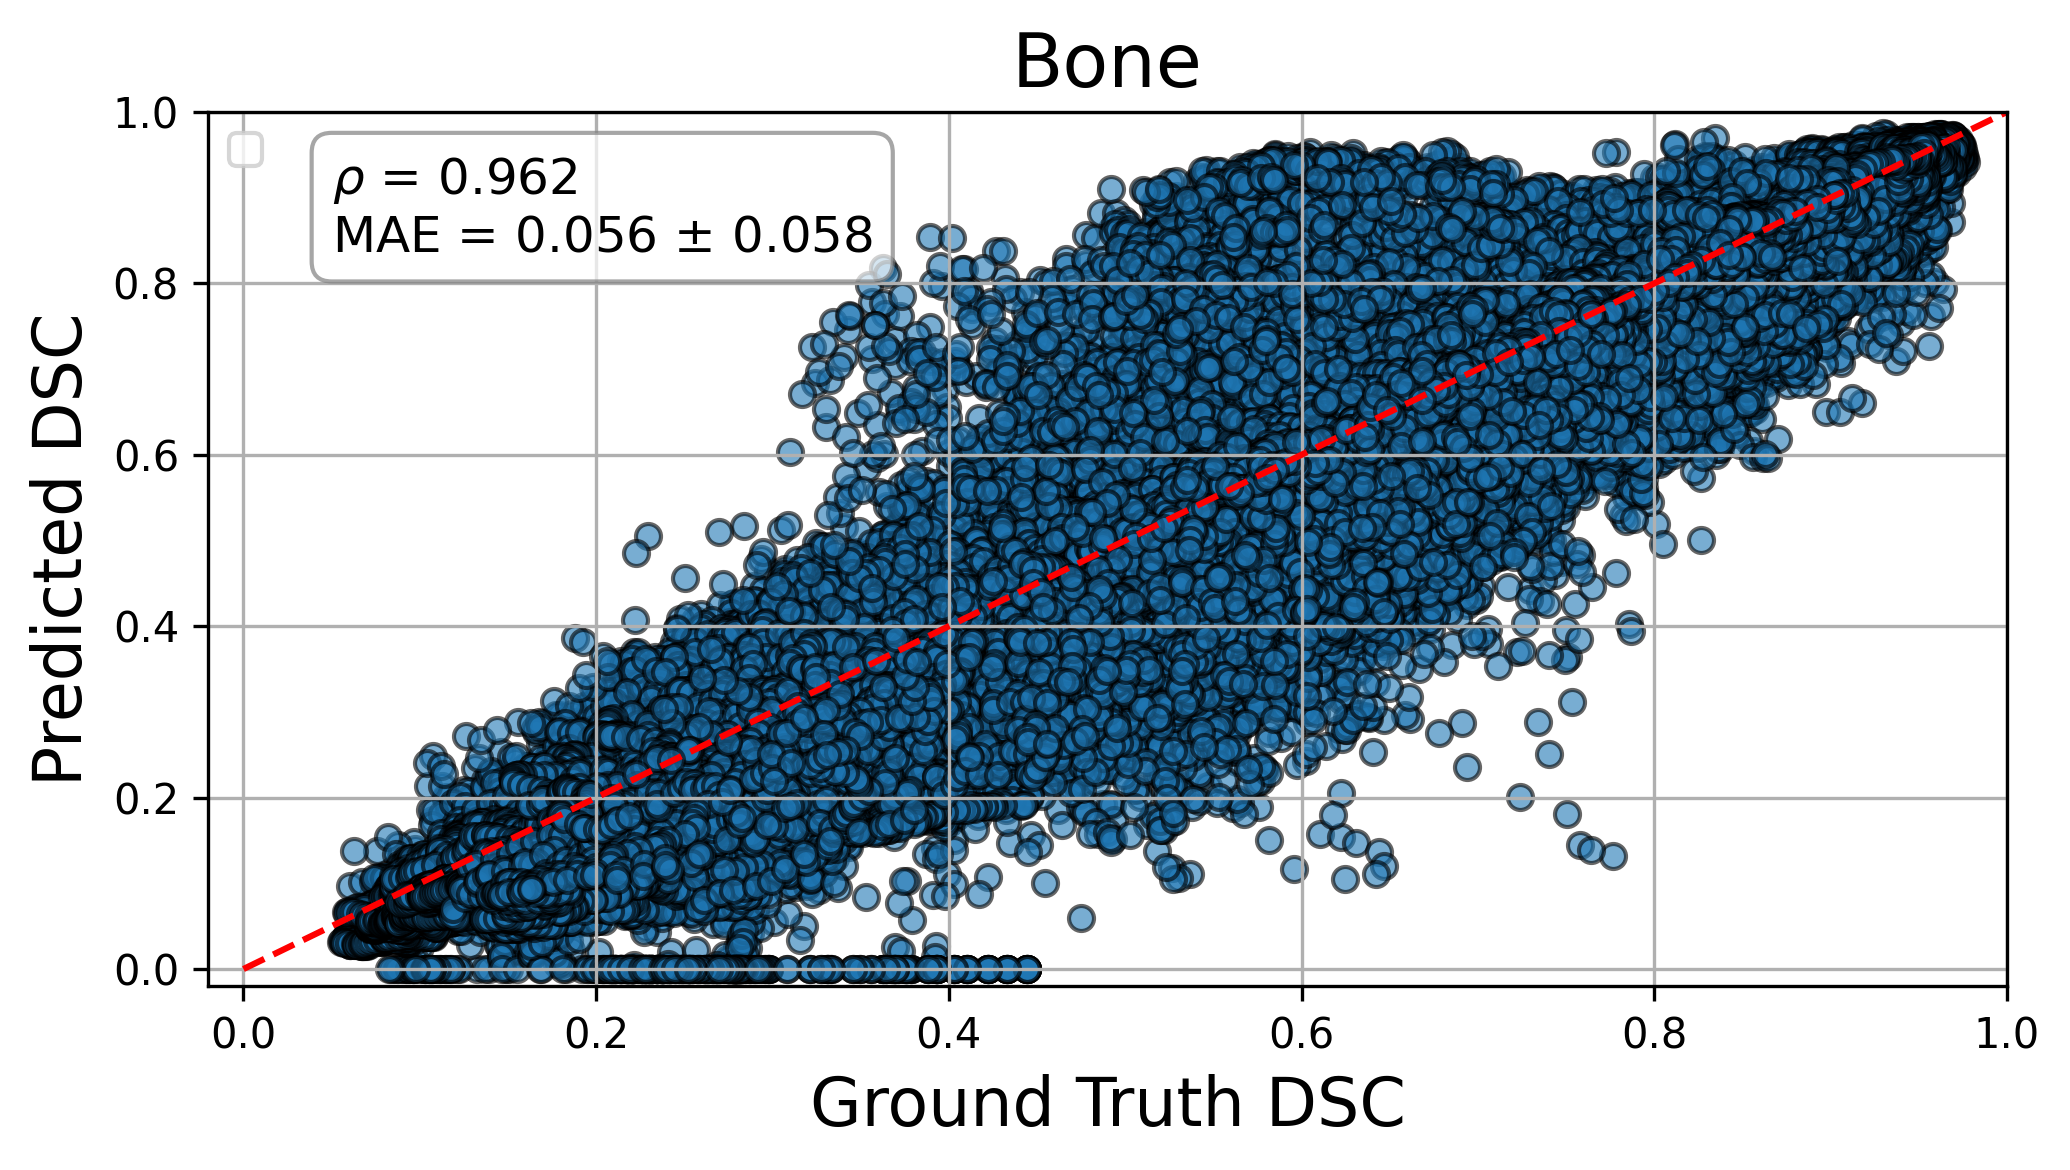

In [62]:
pred_dsc = df['preddsc']
gt_dsc = df['gtdsc']
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

# Example data (replace with your actual arrays)
# pred_dsc = ...
# gt_dsc = ...

# Calculate Pearson correlation coefficient
r, _ = pearsonr(pred_dsc, gt_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))
aeBone2d = np.abs(pred_dsc-gt_dsc)


# Create scatter plot
plt.figure(figsize=(7, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--')



# Combine metrics into one multiline string
metrics_text = fr"$\rho$ = {r:.3f}" + "\n" + fr"MAE = {mae:.3f} $\pm$ {std:.3f}"

# Add single text box
plt.text(0.05, 0.95, metrics_text,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha = 0.7))

# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Bone',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.savefig("corrBone2d.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [63]:
pred = np.array(pred_dsc)
gt = np.array(gt_dsc)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.939


## Save nii.gz files for CT volumetric 

In [357]:
num = 154 
print(caseList[num], pathList[num], gt_dsc[num],pred_dsc[num])

15 /work3/kvabo/predictions/qcBoneDsc0.6 0.537002274947051 0.5501134851661963


In [358]:
nCase = 15
targetClass = 5
targetdsc = 0.6
organ = 'Bone'
qcDirLiver = Path( f"/work3/kvabo/predictions/qc{organ}Dsc{targetdsc}")
df = pd.read_csv(qcDirLiver /"results.csv")
liverSlices = df[(df["case"] == nCase)]

gtSeg0 = np.load(dir / f"labels-{nCase}.npy")
ct_path = dir / f"volume-{nCase}.npy"
Z = []
YHat = []
YZHat = []

n_total_slices = gtSeg0.shape[2]

# Preallocate volume of zeros
pred = np.zeros((512, 512, n_total_slices), dtype=np.float32)


for slice in range(n_total_slices):
    liverMask = np.zeros((512, 512), dtype=np.uint8)

    if slice in liverSlices["slice"].values:
        # Load predicted segmentation
        segPathLiver = qcDirLiver / f"{nCase}_slice_{slice}_pred.npy"
        segLiver = np.load(segPathLiver).astype(np.float32)
    
        # Resize to (512, 512)
        segLiver= Image.fromarray((segLiver * 255).astype(np.uint8))  # convert to image
        segLiver = TF.resize(segLiver, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)
    
        # Convert back to NumPy and binarize if needed
        segLiver = np.array(segLiver).astype(np.uint8) // 255  # back to [0, 1]
        # Set class label
        liverMask = segLiver

    # Assign class labels
    pred[:, :, slice] = liverMask  # kidney=4, liver=1
    
    
nii_path = f"/work3/kvabo/PKGCTORG/CTORG/OrganSegmentations/labels-{nCase}.nii.gz"
nii = nib.load(nii_path)
orig_affine = nii.affine

# Save resized volume with the original affine
nib.save(nib.Nifti1Image(pred, affine=orig_affine), f"{organ}predCase{nCase}dsc{targetdsc}.nii.gz")
#nib.save(nifti_img, f"predicted_seg_case{0}.nii.gz")
GT = (np.array(gtSeg0 == targetClass).astype(np.uint8)).astype(np.float32)
nib.save(nib.Nifti1Image(GT, affine=orig_affine), f"{organ}GTCase{nCase}dsc{targetdsc}.nii.gz")
print(f"{organ}predCase{nCase}dsc{targetdsc}")

BonepredCase15dsc0.6


# Kidney

In [43]:
df = pd.read_csv(Path('evalResultsKidneyFinal.csv'))
predDSC3d = []
gtDSC3d = []
caseList = []
pathList = []
cases = np.arange(21)
eps = 1e-7
for case in cases:
    subjects = df[(df["case"] == case)]
    nSlices = len(subjects)// 9
    for i in range(9):
        subject = subjects[nSlices*i:nSlices*i + nSlices]
        Z = np.sum(subject['z'])
        Y = np.sum(subject['y'])
        YZ = np.sum(subject['yz'])
        gtDSC3d.append((2*YZ/(Y+Z+eps)))
        
        #gtmvsf = subject['gtmvsf']*4-2
        #gtyHat = subject['z']*(2+gtmvsf)/(2-gtmvsf+eps)
        #gtyzHat = 0.5*subject['gtdsc']*(gtyHat + subject['z'])
        
        #gtDSC3d.append(2*np.sum(gtyzHat)/(np.sum(gtyHat)+Z))
        
        mvsf = subject['predmvsf']*4-2
        yHat = subject['z']*(2+mvsf)/(2-mvsf+eps)
        yzHat = 0.5*subject['preddsc']*(yHat + subject['z'])

        pathList.append(subject['path'].iloc[0])
        caseList.append(case)
        predDSC3d.append(2*np.sum(yzHat)/(np.sum(yHat)+Z+eps))


In [245]:
np.where((gt_dsc > 0.85) & (gt_dsc < 0.95))

(array([  0,   9,  18,  19,  27,  28,  36,  37,  45,  46,  54,  55,  63,
         64,  72,  81,  82,  90,  91,  99, 108, 109, 110, 117, 126, 144,
        145, 146, 153, 154, 162, 163, 171]),)

In [246]:
np.where((gt_dsc > 0.15) & (gt_dsc < 0.2))
np.where(np.abs(pred_dsc-gt_dsc) < 0.02)

(array([ 62,  71,  80,  89, 107, 125, 161, 177, 180]),)

In [247]:
np.where(np.abs(pred_dsc-gt_dsc) < 0.02)

(array([  0,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  15,
         16,  17,  20,  21,  22,  27,  43,  44,  45,  46,  51,  53,  56,
         57,  58,  59,  61,  62,  71,  74,  75,  76,  77,  78,  79,  80,
         84,  88,  89,  93,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        109, 110, 111, 112, 115, 116, 120, 121, 125, 126, 127, 129, 130,
        131, 132, 133, 134, 135, 138, 139, 140, 141, 142, 143, 146, 151,
        155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 168, 169, 170,
        173, 178, 184, 186]),)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


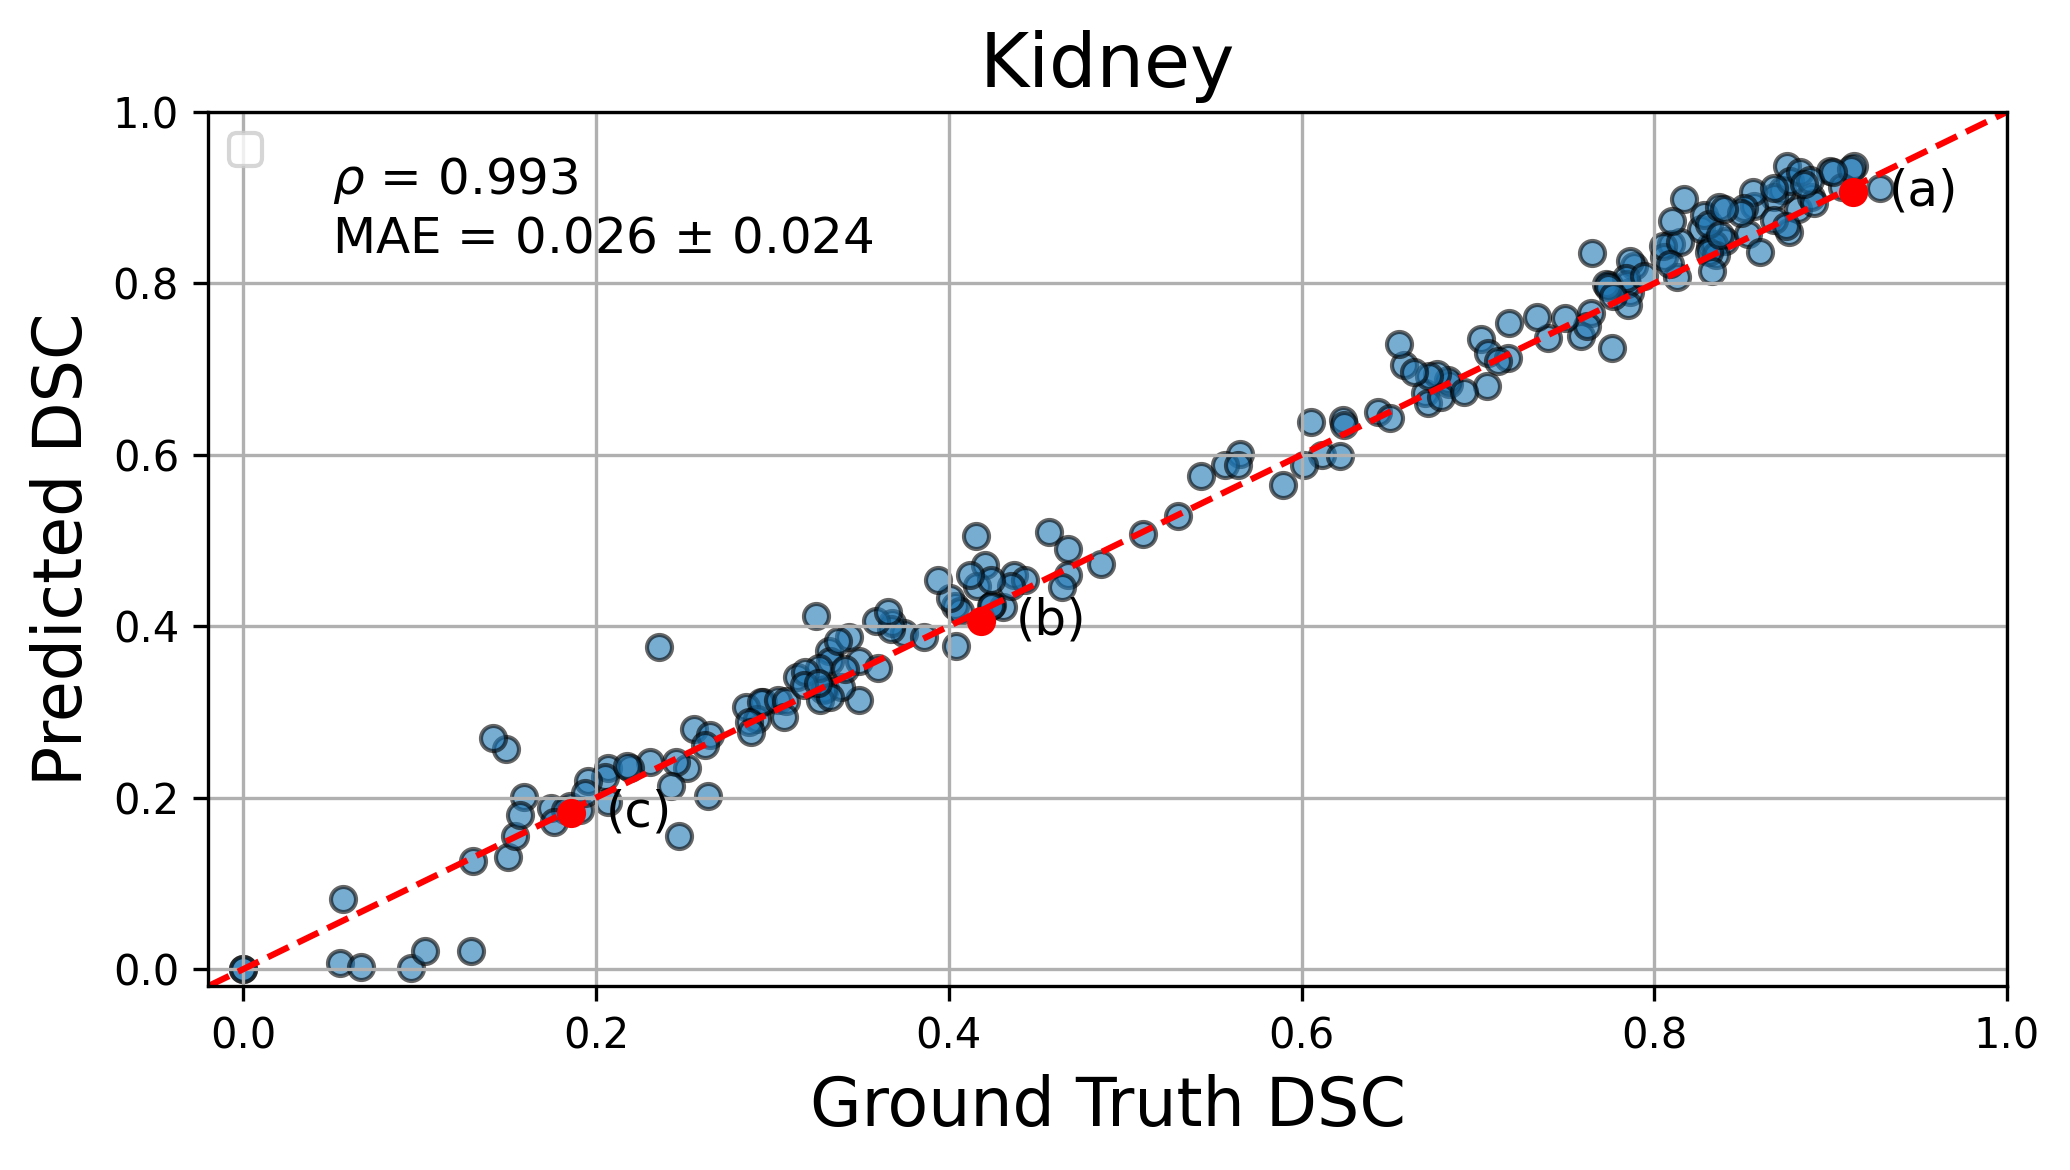

In [44]:
pred_dsc = np.array(predDSC3d )
gt_dsc = np.array(gtDSC3d)
r, _ = pearsonr(gt_dsc, pred_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))
aeKidney = np.abs(pred_dsc-gt_dsc)

# Create scatter plot
plt.figure(figsize=(7, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([-0.02, 1], [-0.02, 1], 'r--')
plt.plot(gt_dsc[99], pred_dsc[99], 'o', markersize=6, color='red')
plt.text(gt_dsc[99] + 0.02, pred_dsc[99], "(a)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[77], pred_dsc[77], 'o', markersize=6, color='red')
plt.text(gt_dsc[77] + 0.02, pred_dsc[77], "(b)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[125], pred_dsc[125], 'o', markersize=6, color='red')
plt.text(gt_dsc[125] + 0.02, pred_dsc[125], "(c)", fontsize=12, verticalalignment='center')

# Add metrics as text in the plot
plt.text(0.05, 0.95, fr"$\rho$ = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, fr"MAE = {mae:.3f} $\pm$ {std:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Kidney',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.savefig("corrKidney.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [45]:
pred = np.array(predDSC3d)
gt = np.array(gtDSC3d)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.984


## 2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


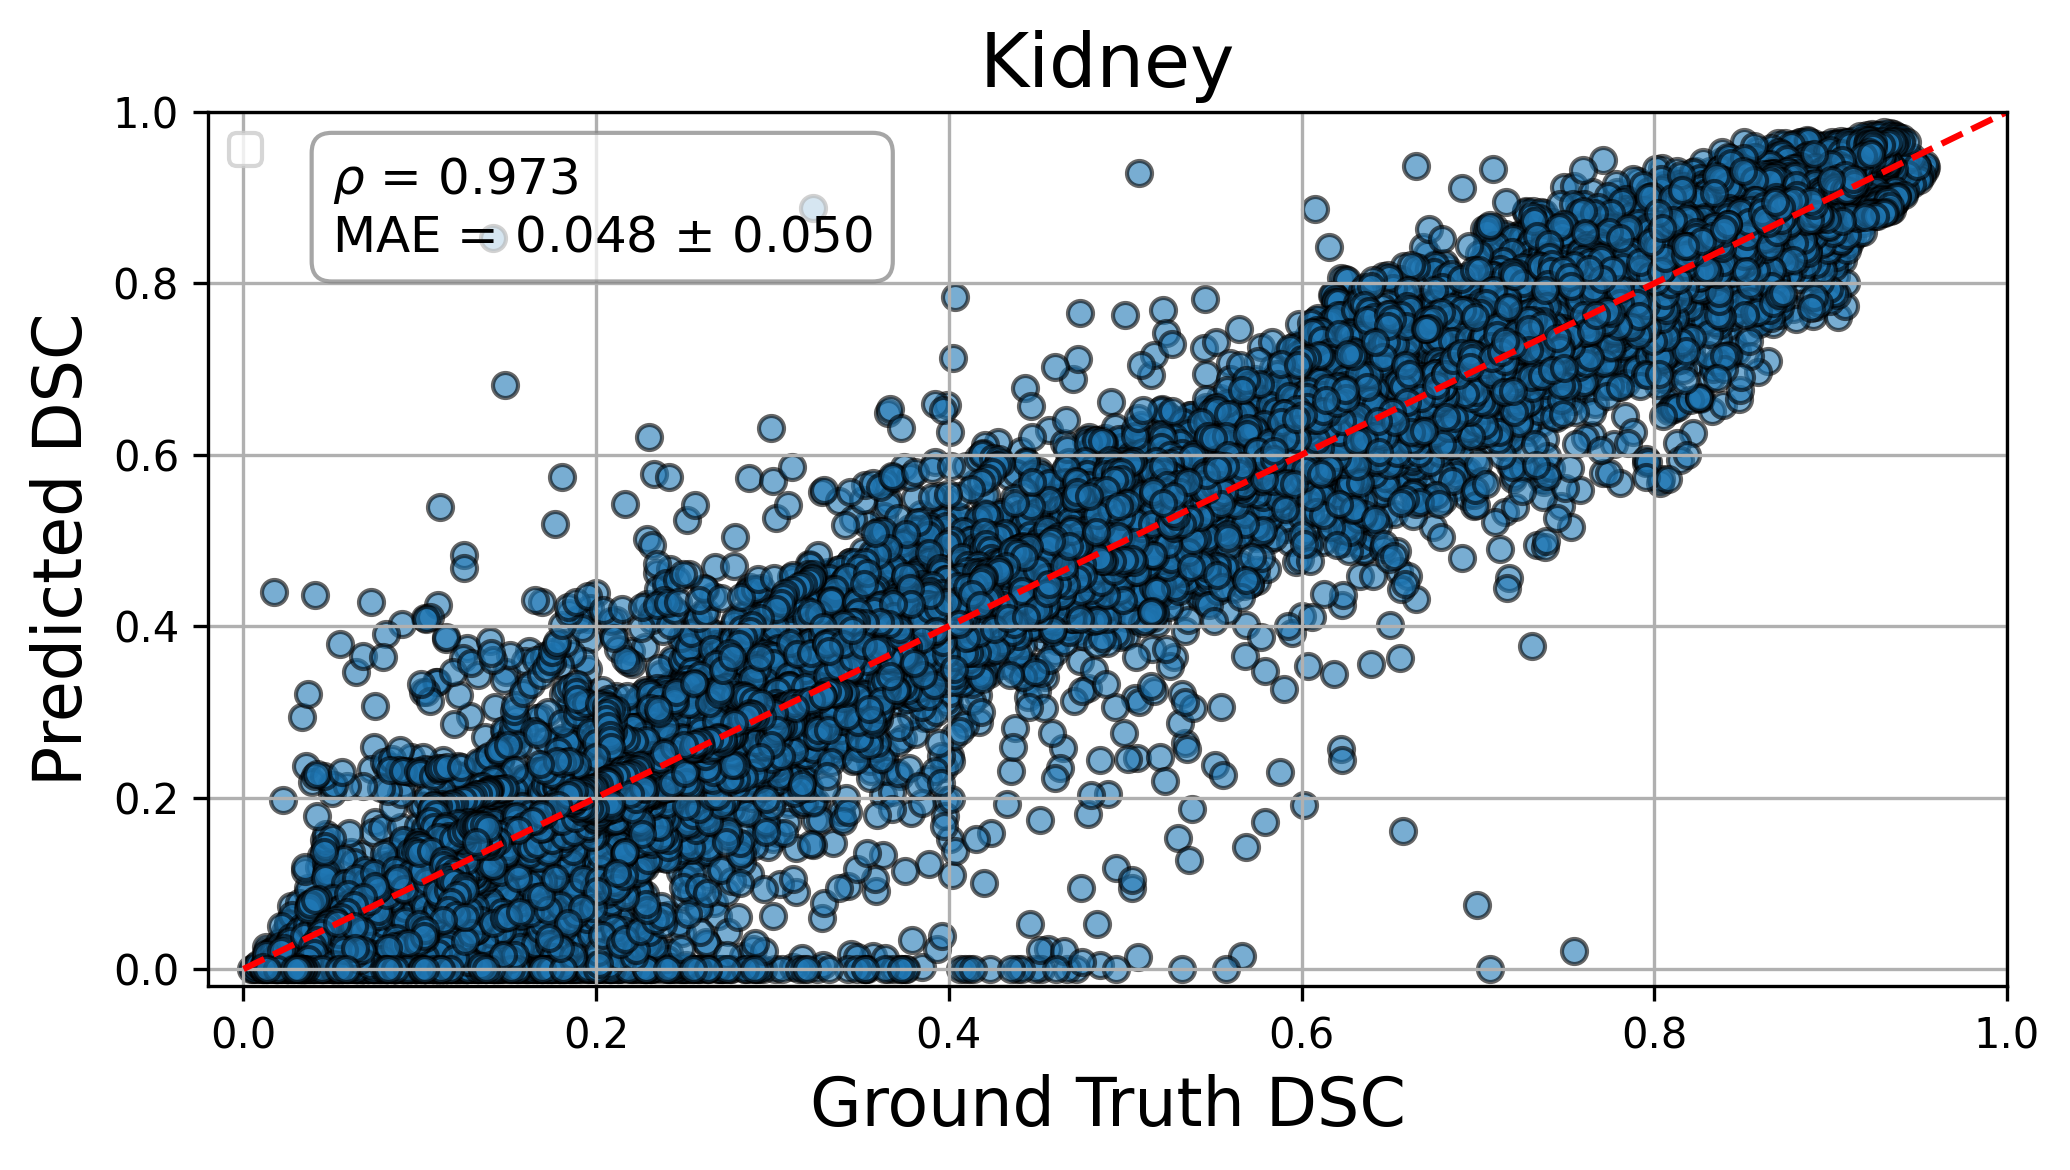

In [46]:
pred_dsc = df['preddsc']
gt_dsc = df['gtdsc']
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

# Example data (replace with your actual arrays)
# pred_dsc = ...
# gt_dsc = ...

# Calculate Pearson correlation coefficient
r, _ = pearsonr(pred_dsc, gt_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))
aeKidney2d = np.abs(pred_dsc-gt_dsc)


# Create scatter plot
plt.figure(figsize=(7, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--')



# Combine metrics into one multiline string
metrics_text = fr"$\rho$ = {r:.3f}" + "\n" + fr"MAE = {mae:.3f} $\pm$ {std:.3f}"

# Add single text box
plt.text(0.05, 0.95, metrics_text,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray', alpha = 0.7))

# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Kidney',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.savefig("corrKidney2d.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [48]:
pred = np.array(pred_dsc)
gt = np.array(gt_dsc)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.961


## Save nii.gz files for CT volumetric 

In [249]:
num = 99
print(caseList[num], pathList[num], gt_dsc[num],pred_dsc[num])

11 /work3/kvabo/predictions/qcKidneyDsc1.0 0.91288403155869 0.9066735340361928


In [235]:
nCase = 8
targetClass = 4
targetdsc = 0.5
organ = 'Kidney'
qcDirLiver = Path( f"/work3/kvabo/predictions/qc{organ}Dsc{targetdsc}")
df = pd.read_csv(qcDirLiver /"resultsUpdate.csv")
liverSlices = df[(df["case"] == nCase)]

gtSeg0 = np.load(dir / f"labels-{nCase}.npy")
ct_path = dir / f"volume-{nCase}.npy"
Z = []
YHat = []
YZHat = []

n_total_slices = gtSeg0.shape[2]

# Preallocate volume of zeros
pred = np.zeros((512, 512, n_total_slices), dtype=np.float32)


for slice in range(n_total_slices):
    liverMask = np.zeros((512, 512), dtype=np.uint8)

    if slice in liverSlices["slice"].values:
        # Load predicted segmentation
        segPathLiver = qcDirLiver / f"{nCase}_slice_{slice}_pred.npy"
        segLiver = np.load(segPathLiver).astype(np.float32)
    
        # Resize to (512, 512)
        segLiver= Image.fromarray((segLiver * 255).astype(np.uint8))  # convert to image
        segLiver = TF.resize(segLiver, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)
    
        # Convert back to NumPy and binarize if needed
        segLiver = np.array(segLiver).astype(np.uint8) // 255  # back to [0, 1]
        # Set class label
        liverMask = segLiver

    # Assign class labels
    pred[:, :, slice] = liverMask  # kidney=4, liver=1
    
    
nii_path = f"/work3/kvabo/PKGCTORG/CTORG/OrganSegmentations/labels-{nCase}.nii.gz"
nii = nib.load(nii_path)
orig_affine = nii.affine

# Save resized volume with the original affine
nib.save(nib.Nifti1Image(pred, affine=orig_affine), f"{organ}predCase{nCase}dsc{targetdsc}.nii.gz")
#nib.save(nifti_img, f"predicted_seg_case{0}.nii.gz")


In [236]:
GT = (np.array(gtSeg0 == targetClass).astype(np.uint8)).astype(np.float32)
nib.save(nib.Nifti1Image(GT, affine=orig_affine), f"{organ}GTCase{nCase}dsc{targetdsc}.nii.gz")

### Accuracy

In [250]:
pred = np.array(predDSC3d)
gt = np.array(gtDSC3d)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.984


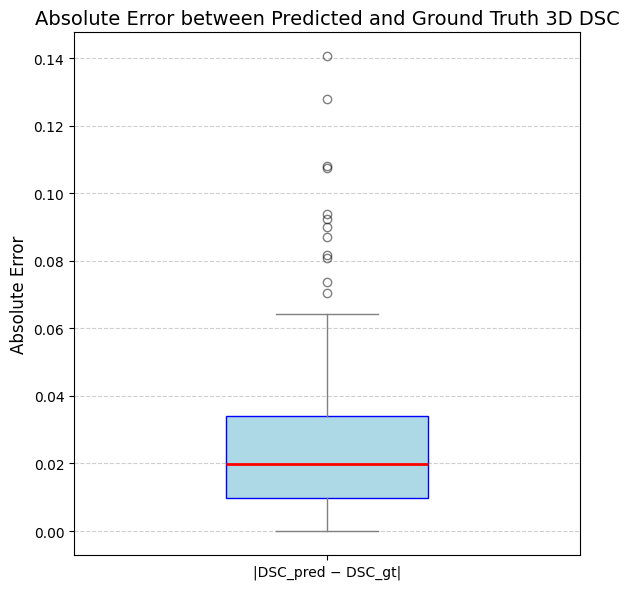

In [251]:
plt.figure(figsize=(6, 6))
plt.boxplot(np.abs(np.array(predDSC3d) - np.array(gtDSC3d)), widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))

plt.title("Absolute Error between Predicted and Ground Truth 3D DSC", fontsize=14)
plt.ylabel("Absolute Error", fontsize=12)
plt.xticks([1], ['|DSC_pred − DSC_gt|'])  # Single box, centered
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

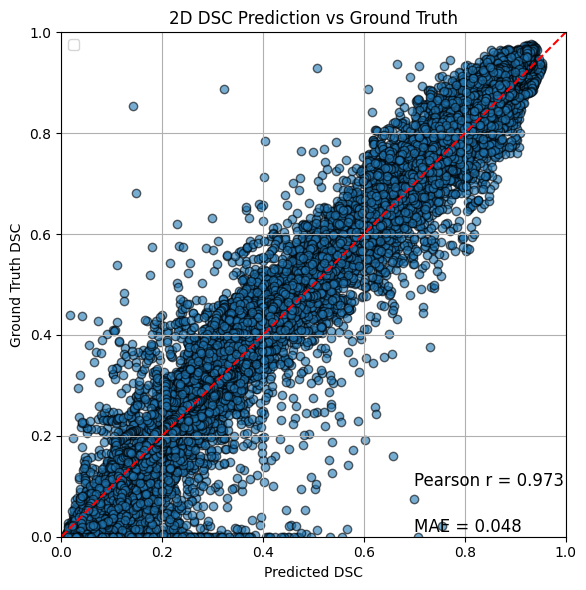

In [365]:
pred_dsc = df['preddsc']
gt_dsc = df['gtdsc']
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

# Example data (replace with your actual arrays)
# pred_dsc = ...
# gt_dsc = ...

# Calculate Pearson correlation coefficient
r, _ = pearsonr(pred_dsc, gt_dsc)

# Calculate Mean Absolute Error
mae = mean_absolute_error(gt_dsc, pred_dsc)

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--')

# Add metrics as text in the plot
plt.text(0.7, 0.1, f"Pearson r = {r:.3f}", fontsize=12)
plt.text(0.7, 0.01, f"MAE = {mae:.3f}", fontsize=12)

# Labels and formatting
plt.xlabel('Predicted DSC')
plt.ylabel('Ground Truth DSC')
plt.title('2D DSC Prediction vs Ground Truth')
plt.grid(True)
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
pred = pred_dsc
gt = gt_dsc

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.961


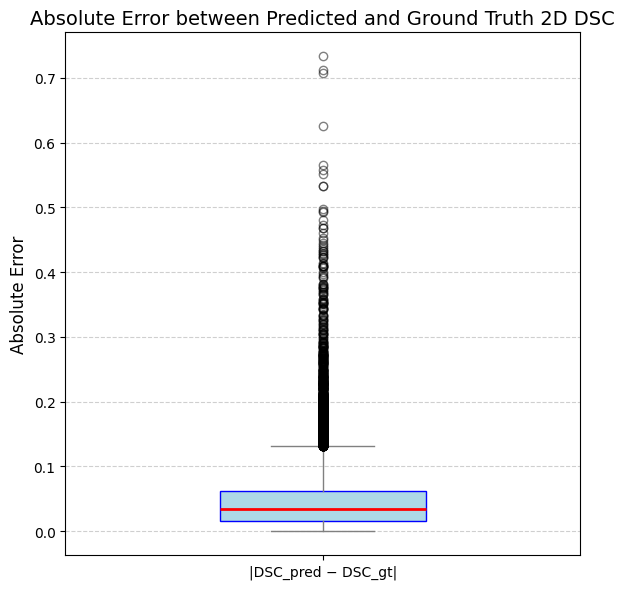

In [62]:
plt.figure(figsize=(6, 6))
plt.boxplot(np.abs(pred_dsc - gt_dsc), widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))

plt.title("Absolute Error between Predicted and Ground Truth 2D DSC", fontsize=14)
plt.ylabel("Absolute Error", fontsize=12)
plt.xticks([1], ['|DSC_pred − DSC_gt|'])  # Single box, centered
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [67]:
0.988**(0.5)

0.9939818911831342

# Bone

In [56]:
df = pd.read_csv(Path('evalResultsBoneFinal.csv'))
predDSC3d = []
gtDSC3d = []
caseList = []
pathList = []
cases = np.arange(21)
eps = 1e-7
for case in cases:
    subjects = df[(df["case"] == case)]
    nSlices = len(subjects)// 10
    for i in range(10):
        subject = subjects[nSlices*i:nSlices*i + nSlices]
        Z = np.sum(subject['z'])
        Y = np.sum(subject['y'])
        YZ = np.sum(subject['yz'])
        gtDSC3d.append((2*YZ/(Y+Z+eps)))
        
        #gtmvsf = subject['gtmvsf']*4-2
        #gtyHat = subject['z']*(2+gtmvsf)/(2-gtmvsf+eps)
        #gtyzHat = 0.5*subject['gtdsc']*(gtyHat + subject['z'])
        
        #gtDSC3d.append(2*np.sum(gtyzHat)/(np.sum(gtyHat)+Z))
        
        mvsf = subject['predmvsf']*4-2
        yHat = subject['z']*(2+mvsf)/(2-mvsf+eps)
        yzHat = 0.5*subject['preddsc']*(yHat + subject['z'])

        pathList.append(subject['path'].iloc[0])
        caseList.append(case)
        predDSC3d.append(2*np.sum(yzHat)/(np.sum(yHat)+Z+eps))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


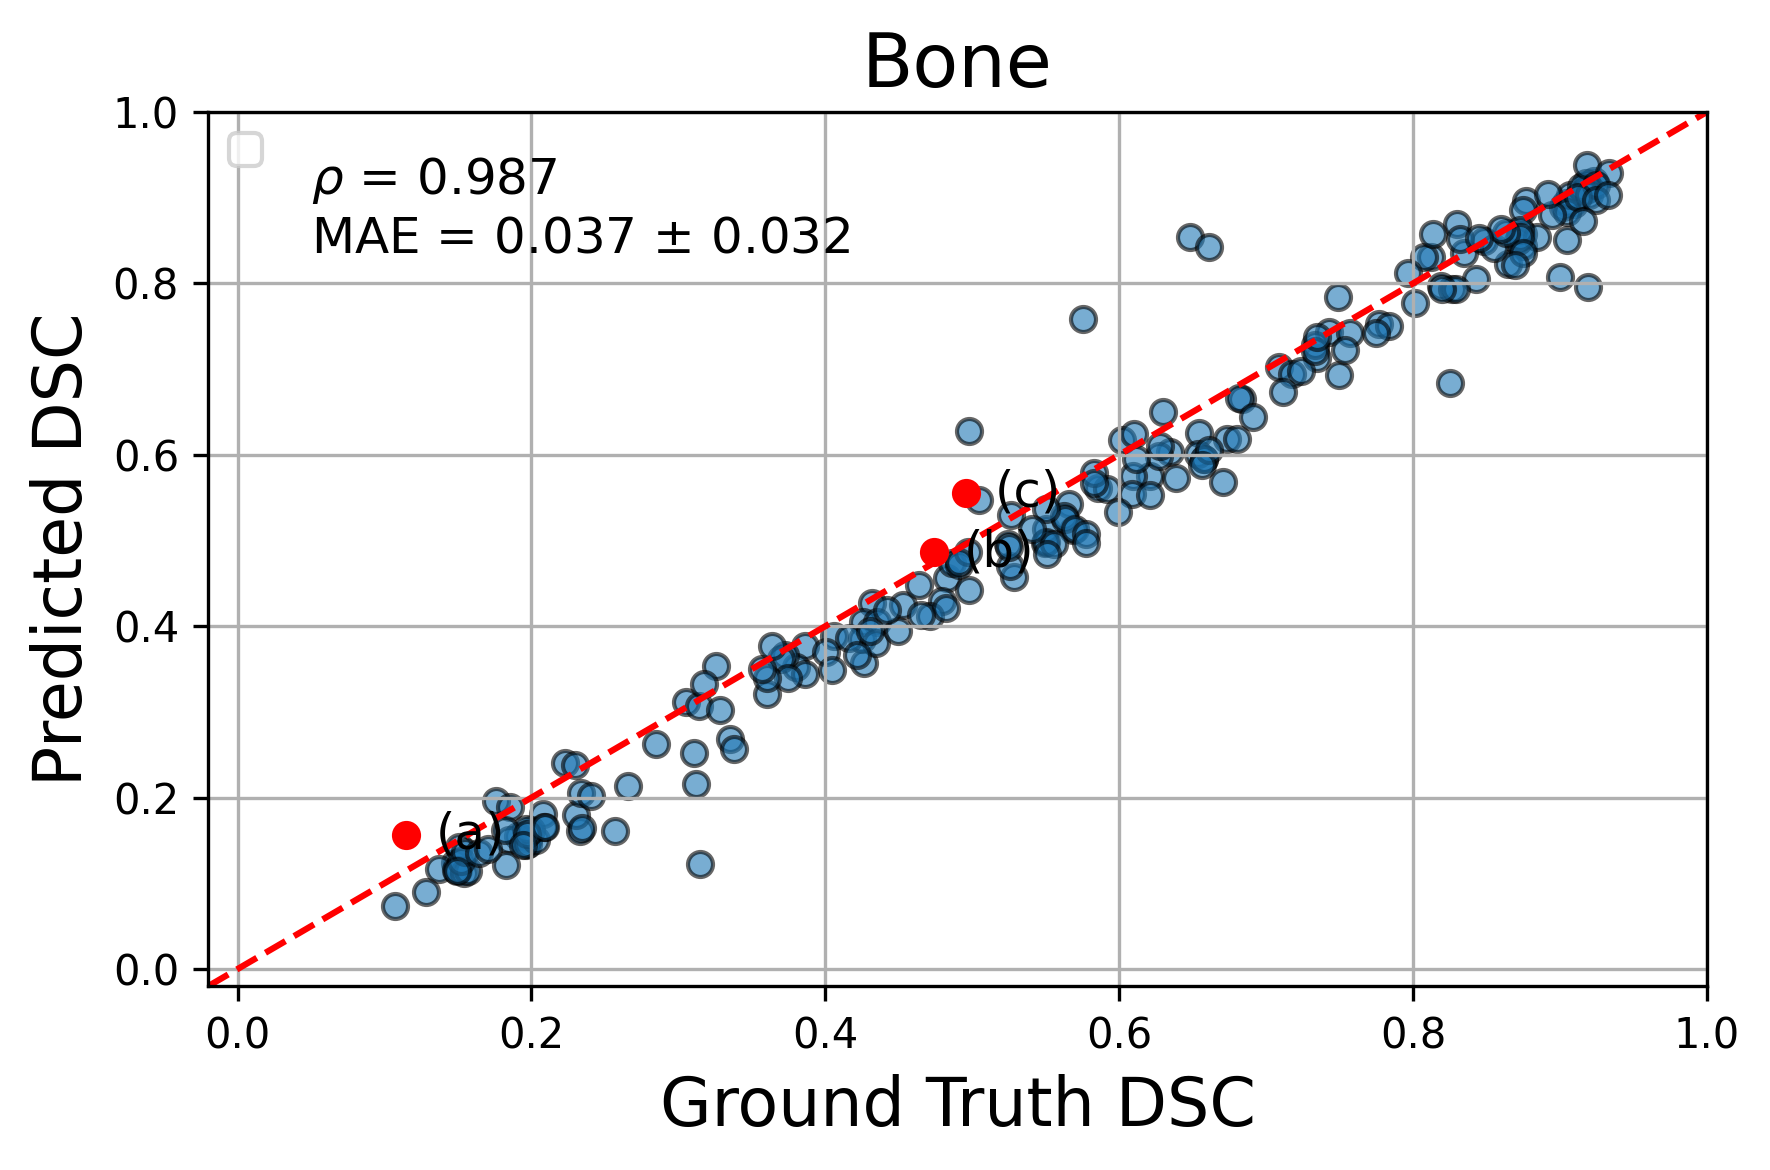

In [57]:
pred_dsc = np.array(predDSC3d )
gt_dsc = np.array(gtDSC3d)
r, _ = pearsonr(gt_dsc, pred_dsc)

# Calculate Mean Absolute Error
std = np.std(np.abs(pred_dsc-gt_dsc))
mae = np.mean(np.abs(pred_dsc-gt_dsc))
aeBone = np.abs(pred_dsc-gt_dsc)

# Create scatter plot
plt.figure(figsize=(6, 4),dpi=300)
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([-0.02, 1], [-0.02, 1], 'r--')
plt.plot(gt_dsc[99], pred_dsc[99], 'o', markersize=6, color='red')
plt.text(gt_dsc[99] + 0.02, pred_dsc[99], "(a)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[77], pred_dsc[77], 'o', markersize=6, color='red')
plt.text(gt_dsc[77] + 0.02, pred_dsc[77], "(b)", fontsize=12, verticalalignment='center')

plt.plot(gt_dsc[125], pred_dsc[125], 'o', markersize=6, color='red')
plt.text(gt_dsc[125] + 0.02, pred_dsc[125], "(c)", fontsize=12, verticalalignment='center')

# Add metrics as text in the plot
plt.text(0.05, 0.95, fr"$\rho$ = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, fr"MAE = {mae:.3f} $\pm$ {std:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.ylabel('Predicted DSC',fontsize=16)
plt.xlabel('Ground Truth DSC',fontsize=16)
plt.title('Bone',fontsize=18)
plt.grid(True)
plt.xlim(-0.02, 1)
plt.ylim(-0.02, 1)
plt.legend()
plt.tight_layout()
plt.savefig("corrBone.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [58]:
pred = np.array(predDSC3d)
gt = np.array(gtDSC3d)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.962


# Boxplot for all organs

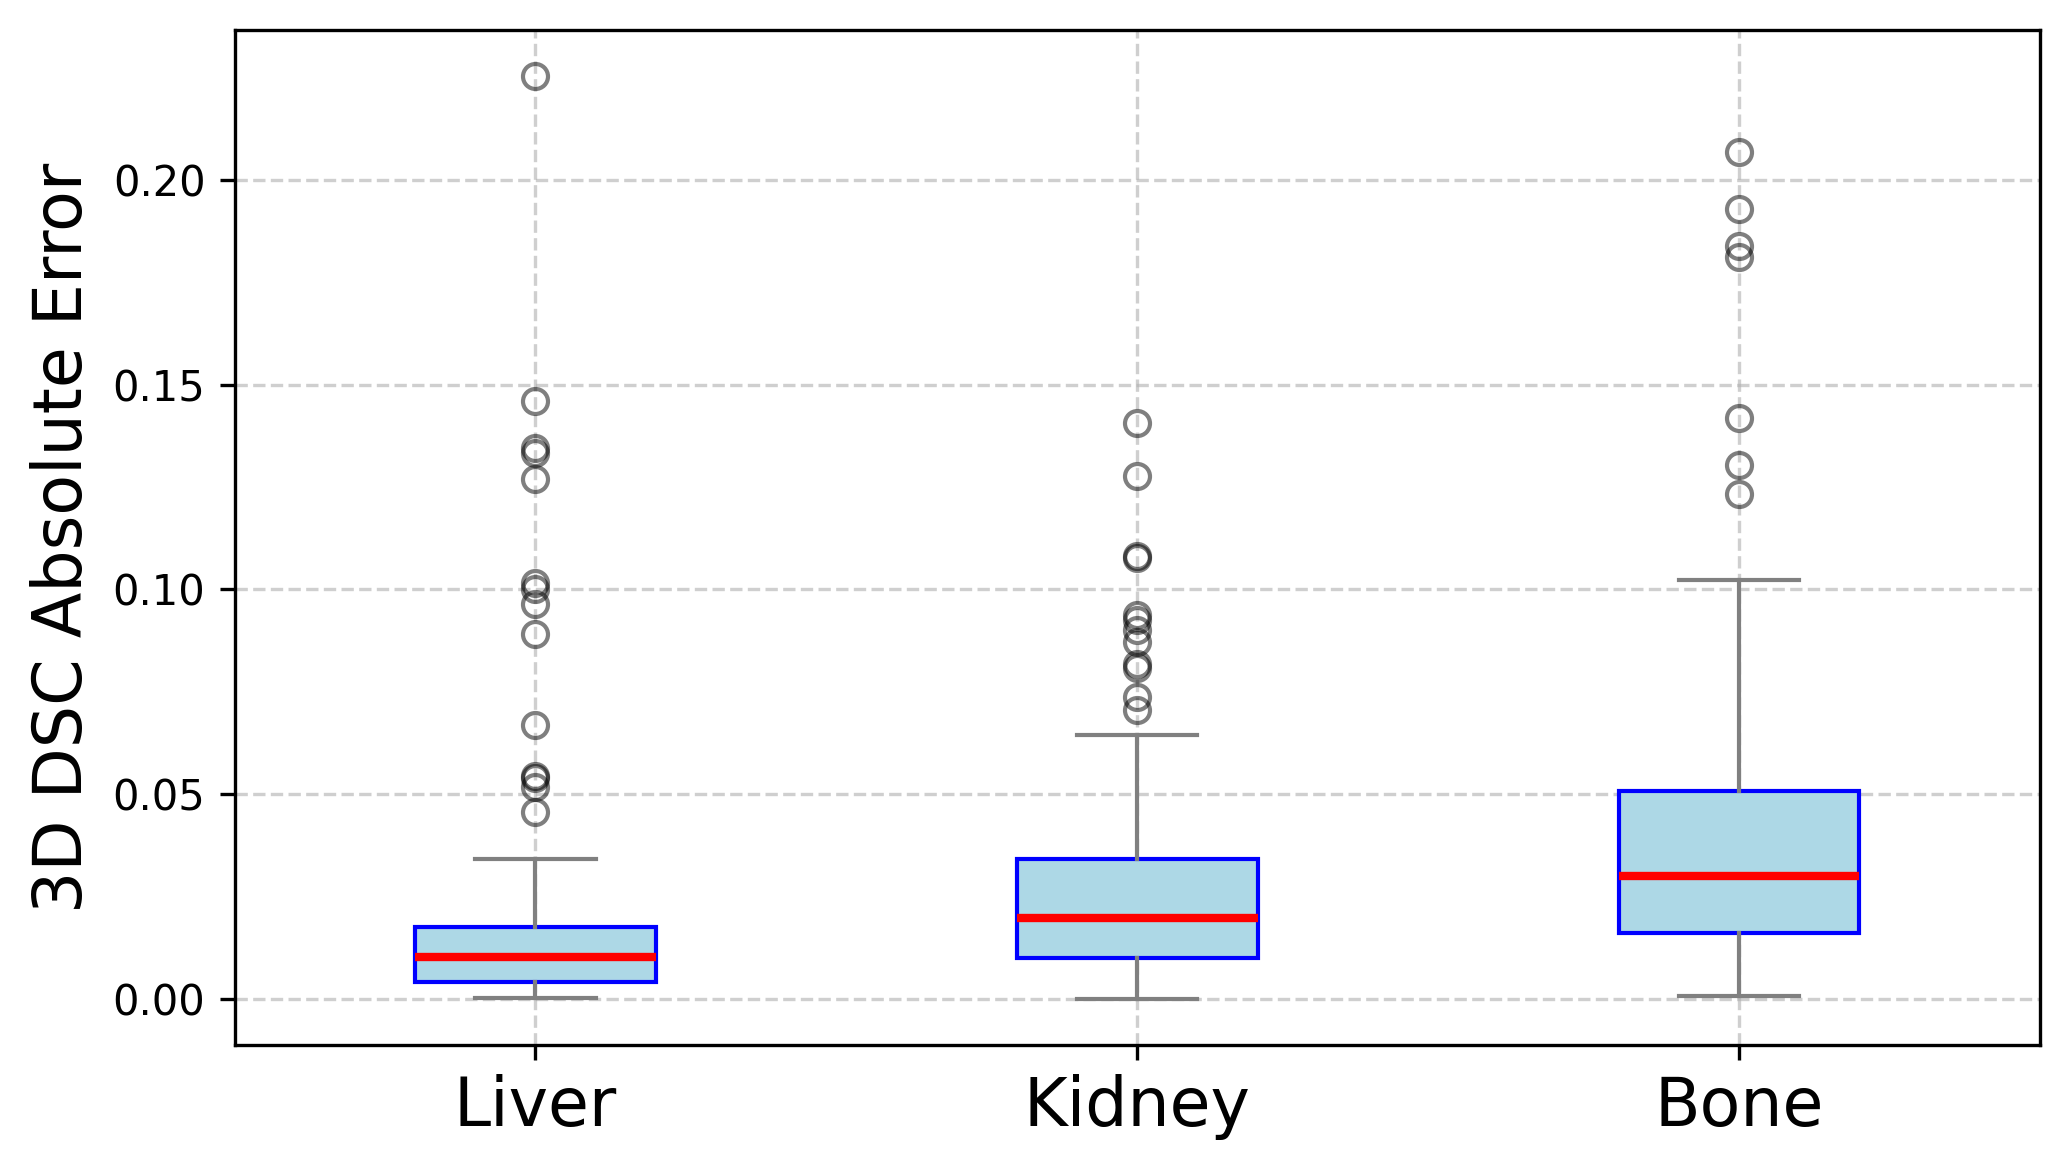

In [275]:


# Organize accuracies into lists
accuracies = [
    aeLiver,
    aeKidney,
    aeBone
]

# Boxplot
plt.figure(figsize=(7, 4), dpi = 300)
plt.boxplot(accuracies, labels=["Liver", "Kidney", "Bone"], widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))
#plt.title("Absolute Error between Predicted and Ground Truth 2D DSC", fontsize=14)

# Make tick labels larger
plt.xticks(fontsize=16)
plt.ylabel("3D DSC Absolute Error", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("boxplot3Ddsc.pdf", dpi=300, bbox_inches="tight")
plt.show()

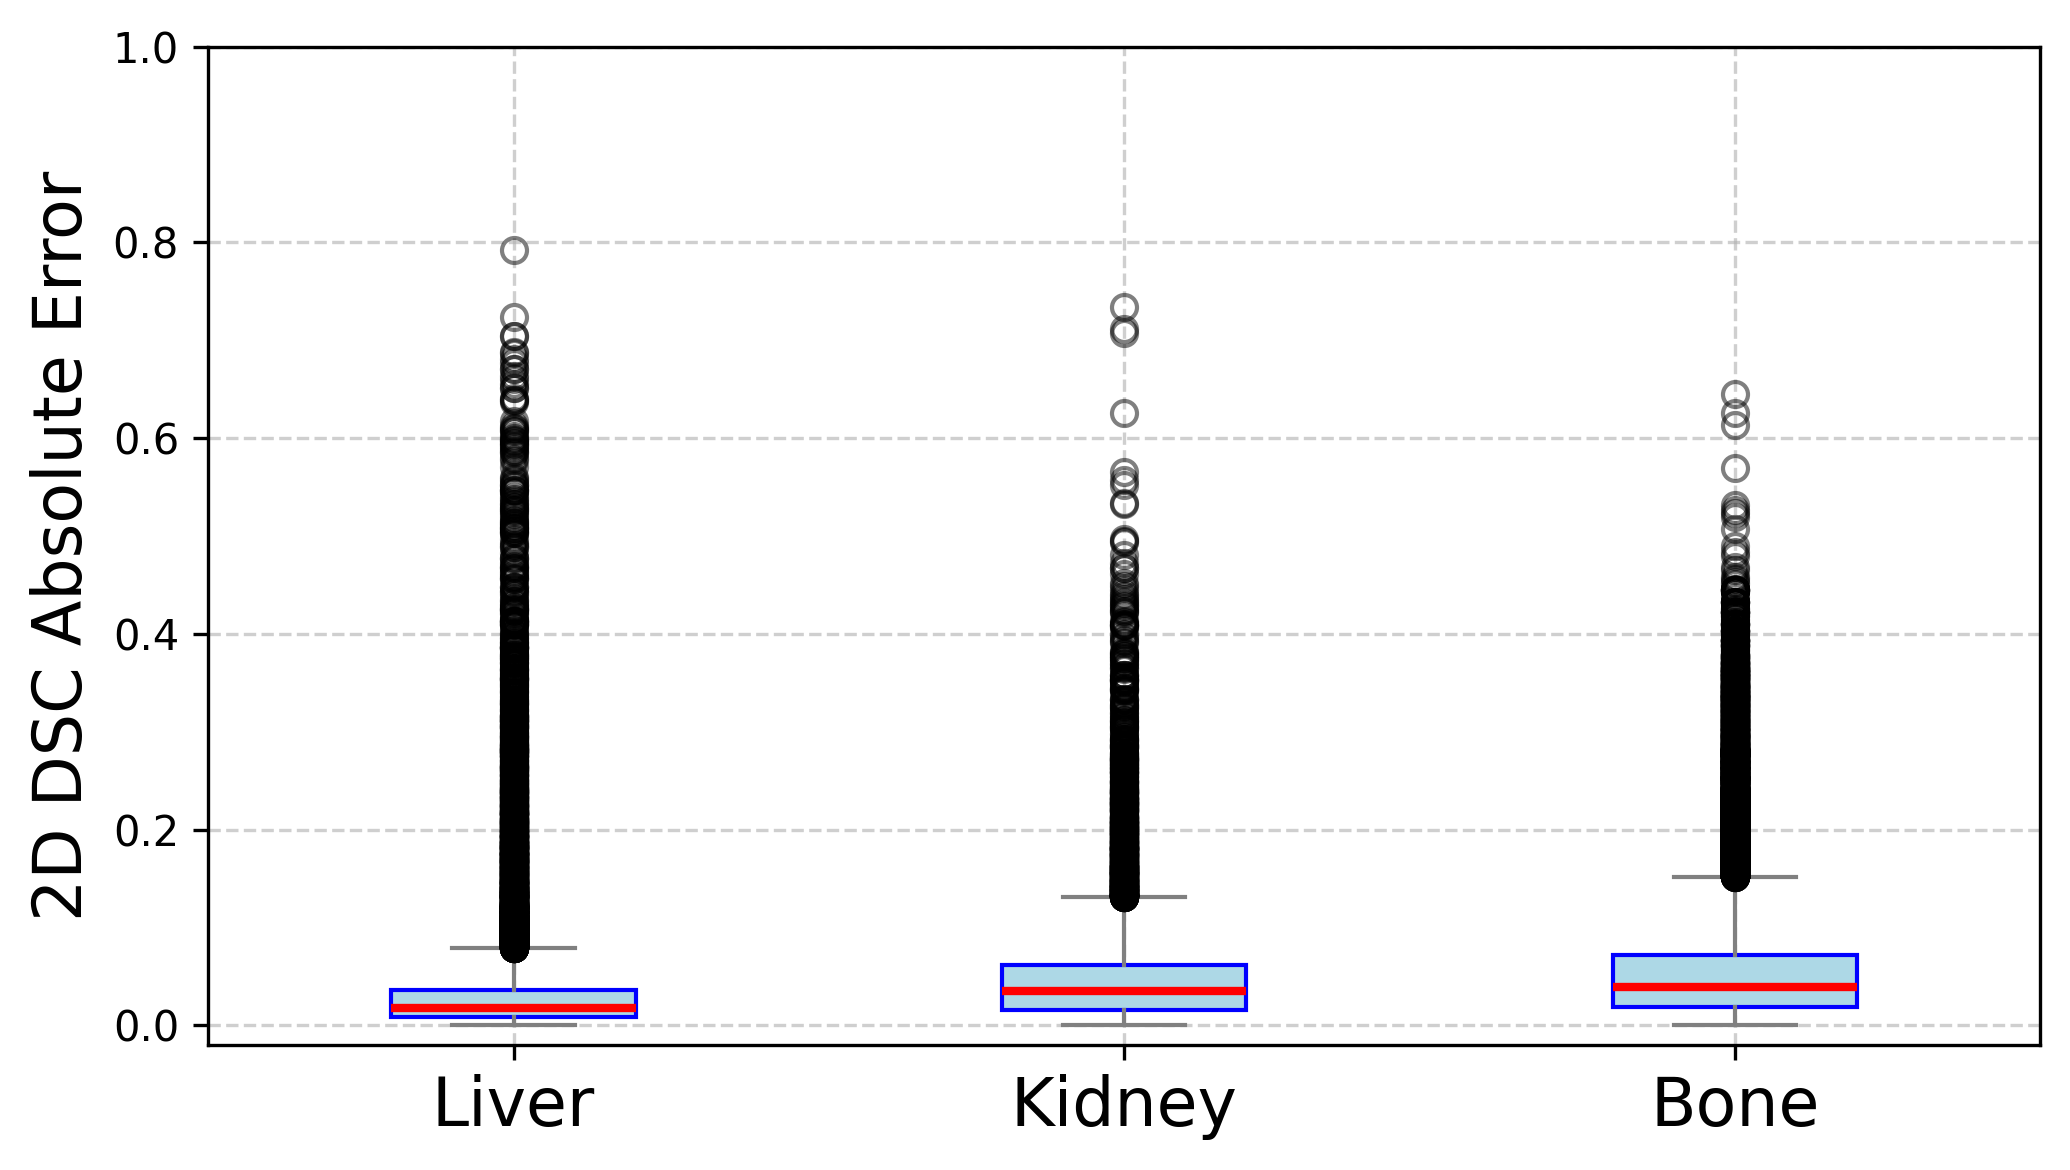

In [137]:


# Organize accuracies into lists
accuracies = [
    aeLiver2d,
    aeKidney2d,
    aeBone2d
]

# Boxplot
plt.figure(figsize=(7, 4), dpi = 300)
plt.boxplot(accuracies, labels=["Liver", "Kidney", "Bone"], widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))
#plt.title("Absolute Error between Predicted and Ground Truth 2D DSC", fontsize=14)

# Make tick labels larger
plt.xticks(fontsize=16)
plt.ylabel("2D DSC Absolute Error", fontsize=16)
plt.ylim(-0.02, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("boxplot2Ddsc.pdf", dpi=300, bbox_inches="tight")
plt.show()

# MVSF 

In [125]:
dfLiver = pd.read_csv(Path('evalResultsLiverfinal.csv'))
dfKidney = pd.read_csv(Path('evalResultsKidneyFinal.csv'))
dfBone = pd.read_csv(Path('evalResultsBoneFinal.csv'))

In [126]:
aeMVSFLiver = np.abs((dfLiver['predmvsf']*4-2)-(dfLiver['gtmvsf']*4-2))
aeMVSFKidney = np.abs((dfKidney['predmvsf']*4-2)-(dfKidney['gtmvsf']*4-2))
aeMVSFBone = np.abs((dfBone['predmvsf']*4-2)-(dfBone['gtmvsf']*4-2))

In [130]:
aeMVSFLiver = np.abs((dfLiver['predmvsf'])-(dfLiver['gtmvsf']))
aeMVSFKidney = np.abs((dfKidney['predmvsf'])-(dfKidney['gtmvsf']))
aeMVSFBone = np.abs((dfBone['predmvsf'])-(dfBone['gtmvsf']))

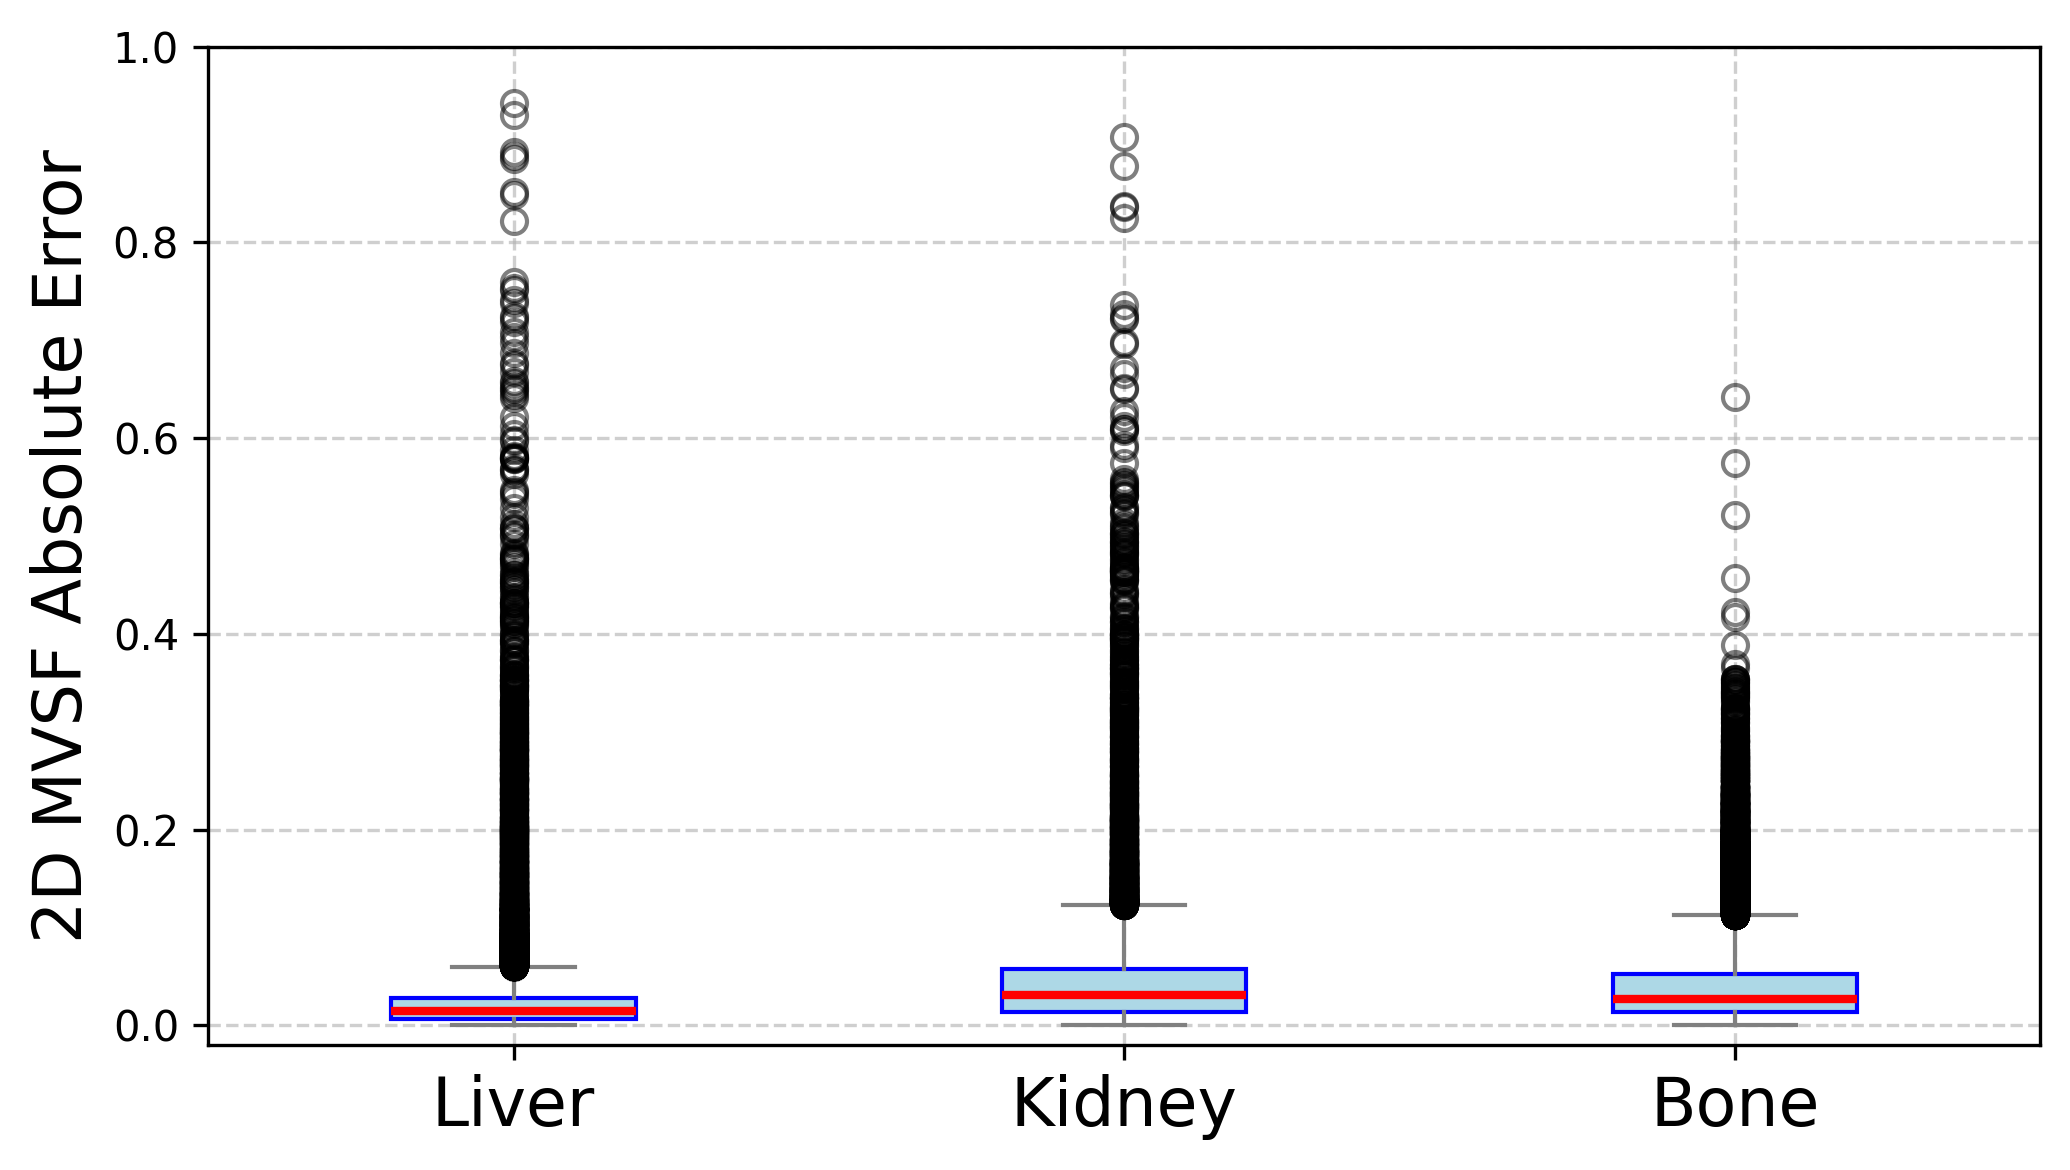

In [136]:
# Organize accuracies into lists
accuracies = [
    aeMVSFLiver,
    aeMVSFKidney,
    aeMVSFBone
]


# Boxplot
plt.figure(figsize=(7, 4), dpi = 300)
plt.boxplot(accuracies, labels=["Liver", "Kidney", "Bone"], widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))
#plt.title("Absolute Error between Predicted and Ground Truth 2D DSC", fontsize=14)

# Make tick labels larger
plt.xticks(fontsize=16)
plt.ylabel("2D MVSF Absolute Error", fontsize=16)
plt.ylim(-0.02, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("boxplot2Dmvsf.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Evaluating computation time

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt
import csv

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import functional as TF
import torch.nn.init as init
from torchsummary import summary

# Image preprocessing
from skimage.transform import resize

# Model and training utilities
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# Setup
import logging
import pickle 
import argparse
from functools import lru_cache
import time

In [65]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir = Path("/work3/kvabo/PKGCTORG/newCT")

organ = 'Bone'

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        return self.block(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.pool(x_conv)
        return x_pool, x_conv

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.block = nn.Sequential(
            nn.BatchNorm2d(out_channels + skip_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((skip, x), dim=1)
        return self.block(x)

class QCUNet(nn.Module):
    def __init__(self, in_channels=2):
        super(QCUNet, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 40)
        self.enc2 = EncoderBlock(40, 40)
        self.enc3 = EncoderBlock(40, 80)
        self.enc4 = EncoderBlock(80, 160)
        self.enc5 = EncoderBlock(160, 320)

        self.bottleneck = ConvBlock(320, 640)

        self.dec5 = DecoderBlock(640, 320, 320)
        self.dec4 = DecoderBlock(320, 160, 160)
        self.dec3 = DecoderBlock(160, 80, 80)
        self.dec2 = DecoderBlock(80, 40, 40)
        self.dec1 = DecoderBlock(40, 40, 40)

        self.output_conv = nn.Conv2d(40, 2, kernel_size=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Outputs shape (B, 1, 1, 1)

    def forward(self, x):
        x1_pool, x1 = self.enc1(x)
        x2_pool, x2 = self.enc2(x1_pool)
        x3_pool, x3 = self.enc3(x2_pool)
        x4_pool, x4 = self.enc4(x3_pool)
        x5_pool, x5 = self.enc5(x4_pool)

        x = self.bottleneck(x5_pool)

        x = self.dec5(x, x5)
        x = self.dec4(x, x4)
        x = self.dec3(x, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)

        x = self.output_conv(x)                    # (B, 1, H, W)
        x = self.global_avg_pool(x)                # (B, 1, 1, 1)
        return x.view(x.size(0), -1)               # Flatten to shape (B, 1)


model = QCUNet()
model_path = f"aqcModel{organ}V3.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

class QCDataset(Dataset):
    def __init__(self, qc_dirs, ct_dir):
        self.ct_dir = Path(ct_dir)

        self.data = []

        # Load and combine all resultsUpdate.csv files
        for qc_dir in qc_dirs:
            qc_path = Path(qc_dir)
            #df = pd.read_csv(qc_path / "resultsUpdate.csv")
            df = pd.read_csv(qc_path / "results.csv")
            df["qc_dir"] = qc_path  # Track where each sample comes from
            self.data.append(df)

        self.data = pd.concat(self.data, ignore_index=True)

        # Sort the data so we consistently run through the same stuff
        # and improve the LRU cache
        self.data = self.data.sort_values(by=["qc_dir", "case", "slice"])

    def __len__(self):
        return len(self.data)

    def load_seq_file(self, qc_dir, case_number, slice_idx):
        # Load segmentation
        seg_path = qc_dir / f"{case_number}_slice_{slice_idx}_pred.npy"
        seg = np.load(seg_path).astype(np.float32)
        seg_tensor = torch.from_numpy(seg).unsqueeze(0)  # shape: [1, 256, 256]
        return seg_tensor

    # The ct file seems huge (volume), reading slices is bad.
    # So likely maxsize shouldn't be too big, start with 1 and see how it performs.
    @lru_cache(maxsize=1)
    def load_ct_file(self, case_number):
        # Load and resize CT slice
        ct_path = self.ct_dir / f"volume-{case_number}.npy"
        ct = np.load(ct_path).astype(np.float32)
        return ct


    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        case_number = int(row['case'])
        slice_idx = int(row['slice'])
        qc_dir = Path(row['qc_dir'])

        # Target vector: [DSC, MVSF]
        Y = torch.tensor([row['dsc'], row['mvsf']], dtype=torch.float32)

        seg_tensor = self.load_seq_file(qc_dir, case_number, slice_idx)

        # Load and resize CT slice
        ct = self.load_ct_file(case_number)[..., slice_idx]
        ct_tensor = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, H, W]
        ct_resized = F.interpolate(ct_tensor, size=(256, 256), mode='bilinear', align_corners=False)
        ct_resized = ct_resized.squeeze(0)  # shape: [1, 256, 256]

        # Stack CT and segmentation
        X = torch.cat([ct_resized, seg_tensor], dim=0)  # shape: [2, 256, 256]

        return X, Y, case_number, slice_idx, str(qc_dir)

qc_dirs = [
    f"/work3/kvabo/predictions/qc{organ}Dsc1.0",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.9",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.8",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.7",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.6",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.5",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.4",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.3",
    #f"/work3/kvabo/predictions/qc{organ}Dsc0.2"
    #,f"/work3/kvabo/predictions/qc{organ}Dsc0.1"
]

# Load full dataset
full_dataset = QCDataset(qc_dirs, dir)

# Convert to DataFrame for filtering
full_df = full_dataset.data

# Get indices for test, train, val (only case 0 for test)
#test_indices = full_df.index[full_df['case'] == 1].tolist()
test_indices = full_df.index[full_df['case'].between(0, 20)].tolist()
train_indices = full_df.index[full_df['case'].between(21, 120)].tolist()
val_indices = full_df.index[full_df['case'].between(121, 140)].tolist()

# Create Subsets
val_dataset = Subset(full_dataset, val_indices)
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create Subsets
val_dataset = Subset(full_dataset, val_indices)
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create DataLoaders
batch_size = 40
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False,persistent_workers=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False,persistent_workers=True)



evalResults = []
evalcsv = Path(f"evalResults{organ}single.csv")
targetClass = 5


In [66]:
len(test_dataset)

10402

In [67]:
eps = 1e-7
yzHat = []
YHat = []
Z = []
start_time = time.time()
with torch.no_grad():
    for batch_idx, (X, Y, case_ids, slice_indices, paths) in enumerate(test_loader):
        X = X.to(device)
        Y = Y.to(device)

        outputs = model(X)                          # [B, 2]
        Yhat = torch.sigmoid(outputs)              # [B, 2]

        dsc_error = torch.abs(Yhat[:, 0] - Y[:, 0]) # [B]
        mvsf_error = torch.abs(Yhat[:, 1] - Y[:, 1])
        X = X.detach().cpu().numpy()
        for i in range(X.shape[0]):
            path = paths[i]
            case = case_ids[i].item()
            slice = slice_indices[i].item()

            pred_dsc = Yhat[i, 0].item()
            pred_mvsf = Yhat[i, 1].item()
            predseg = X[i,1,:,:].flatten()
            z = np.sum(predseg)
            Z.append(z)

            mvsf = pred_mvsf*4-2
            yHat = z*(2+mvsf)/(2-mvsf+eps)
            YHat.append(yHat)
            yzHat.append(0.5*pred_dsc*(yHat + z))
    
    DSC3d = 2*np.sum(np.array(yzHat))/(np.sum(np.array(YHat))+np.sum(np.array(Z))+eps)


# End timing
end_time = time.time()
elapsed = end_time - start_time
print(f"Evaluation completed in {elapsed:.10f} seconds.")
print(DSC3d)

Evaluation completed in 45.7880589962 seconds.
0.8896698554109753


In [69]:
(45.7880589962*1000)/21

2180.3837617238096

In [31]:
torch.cuda.empty_cache()

In [71]:
import subprocess

gpu_info = subprocess.getoutput("nvidia-smi")
print(gpu_info)


Tue Jul  1 01:27:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:37:00.0 Off |                    0 |
| N/A   36C    P0             38W /  250W |   13450MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [72]:
df

case  slice                                   path   preddsc  \
0          0      0  /work3/kvabo/predictions/qcBoneDsc1.0  0.951015   
1          0      1  /work3/kvabo/predictions/qcBoneDsc1.0  0.945543   
2          0      2  /work3/kvabo/predictions/qcBoneDsc1.0  0.934650   
3          0      3  /work3/kvabo/predictions/qcBoneDsc1.0  0.923654   
4          0      4  /work3/kvabo/predictions/qcBoneDsc1.0  0.912834   
...      ...    ...                                    ...       ...   
104015    20    524  /work3/kvabo/predictions/qcBoneDsc0.1  0.668325   
104016    20    525  /work3/kvabo/predictions/qcBoneDsc0.1  0.635749   
104017    20    526  /work3/kvabo/predictions/qcBoneDsc0.1  0.589051   
104018    20    527  /work3/kvabo/predictions/qcBoneDsc0.1  0.519786   
104019    20    528  /work3/kvabo/predictions/qcBoneDsc0.1  0.412119   

        predmvsf     gtdsc    gtmvsf       z            y           yz  
0       0.482211  0.844422  0.562298  1479.0  1900.007843  1426.654902  
1       0.466566  0.882928  0.548730  2215.0  2693.364706  2166.866667  
2       0.469081  0.870104  0.557830  2550.0  3217.007843  2508.949020  
3       0.485089  0.811922  0.590679  2642.0  3812.592157  2620.313725  
4       0.491082  0.819055  0.582206  3009.0  4193.117647  2949.466667  
...          ...       ...       ...     ...          ...          ...  
104015  0.438746  0.663562  0.331781  2467.0  1224.901961  1224.901961  
104016  0.453017  0.621200  0.310600  2211.0   996.137255   996.137255  
104017  0.465560  0.547871  0.273936  1971.0   743.635294   743.635294  
104018  0.509222  0.431034  0.215517  1713.0   470.603922   470.603922  
104019  0.545644  0.246931  0.123465  1470.0   207.058824   207.058824  

[104020 rows x 10 columns]

In [76]:
pd.read_csv(f'/work3/kvabo/predictions/qcLiverDsc1.0/resultsUpdate.csv')

case  slice          model       dsc      mvsf         prediction_file
0         0     45  qcLiverDsc1.0  0.681135  0.531180     0_slice_45_pred.npy
1         0     46  qcLiverDsc1.0  0.646582  0.666440     0_slice_46_pred.npy
2         0     47  qcLiverDsc1.0  0.826823  0.540484     0_slice_47_pred.npy
3         0     48  qcLiverDsc1.0  0.917887  0.479560     0_slice_48_pred.npy
4         0     49  qcLiverDsc1.0  0.880519  0.467543     0_slice_49_pred.npy
...     ...    ...            ...       ...       ...                     ...
19448   139    400  qcLiverDsc1.0  0.878717  0.487919  139_slice_400_pred.npy
19449   139    401  qcLiverDsc1.0  0.862745  0.535344  139_slice_401_pred.npy
19450   139    402  qcLiverDsc1.0  0.837533  0.570420  139_slice_402_pred.npy
19451   139    403  qcLiverDsc1.0  0.440418  0.779791  139_slice_403_pred.npy
19452   139    404  qcLiverDsc1.0  0.000000  1.000000  139_slice_404_pred.npy

[19453 rows x 6 columns]

In [77]:
df

case  slice                                   path   preddsc  \
0          0      0  /work3/kvabo/predictions/qcBoneDsc1.0  0.951015   
1          0      1  /work3/kvabo/predictions/qcBoneDsc1.0  0.945543   
2          0      2  /work3/kvabo/predictions/qcBoneDsc1.0  0.934650   
3          0      3  /work3/kvabo/predictions/qcBoneDsc1.0  0.923654   
4          0      4  /work3/kvabo/predictions/qcBoneDsc1.0  0.912834   
...      ...    ...                                    ...       ...   
104015    20    524  /work3/kvabo/predictions/qcBoneDsc0.1  0.668325   
104016    20    525  /work3/kvabo/predictions/qcBoneDsc0.1  0.635749   
104017    20    526  /work3/kvabo/predictions/qcBoneDsc0.1  0.589051   
104018    20    527  /work3/kvabo/predictions/qcBoneDsc0.1  0.519786   
104019    20    528  /work3/kvabo/predictions/qcBoneDsc0.1  0.412119   

        predmvsf     gtdsc    gtmvsf       z            y           yz  
0       0.482211  0.844422  0.562298  1479.0  1900.007843  1426.654902  
1       0.466566  0.882928  0.548730  2215.0  2693.364706  2166.866667  
2       0.469081  0.870104  0.557830  2550.0  3217.007843  2508.949020  
3       0.485089  0.811922  0.590679  2642.0  3812.592157  2620.313725  
4       0.491082  0.819055  0.582206  3009.0  4193.117647  2949.466667  
...          ...       ...       ...     ...          ...          ...  
104015  0.438746  0.663562  0.331781  2467.0  1224.901961  1224.901961  
104016  0.453017  0.621200  0.310600  2211.0   996.137255   996.137255  
104017  0.465560  0.547871  0.273936  1971.0   743.635294   743.635294  
104018  0.509222  0.431034  0.215517  1713.0   470.603922   470.603922  
104019  0.545644  0.246931  0.123465  1470.0   207.058824   207.058824  

[104020 rows x 10 columns]